In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

Importing and processing the USG and ground-based comparison data `csv`, which we use to compute our KDE for speed and radiant uncertainty:

In [2]:
# skip the first two rows after header and the last three rows since those are garbage
# note that we want the usg-ground-based-comparison file to be in this form since we are removing absolute rows
usg_ground_based_comparison = pd.read_csv('usg-ground-based-comparison/usg-ground-based-comparison_EDITED.csv', 
                                          sep = ',', skip_blank_lines=True).iloc[2:-3]  

# forward fill Event and radiant, backward fill dv based on the xlsx file
usg_ground_based_comparison['Event'] = usg_ground_based_comparison['Event'].fillna(method='ffill')
usg_ground_based_comparison['Radiant Diff'] = usg_ground_based_comparison['Radiant Diff'].fillna(method='ffill')
usg_ground_based_comparison['DV'] = usg_ground_based_comparison['DV'].fillna(method='bfill')

# drop every other row since we don't need duplicate rows for event, radiant diff, or dv
# however we want to keep the usg reported speed, zenith angle and other parameters (second row for each event), 
# so we start by dropping the first row rather than the second
usg_ground_based_comparison = usg_ground_based_comparison.iloc[1::2]
# strip whitespace from headers to avoid errors with indexing later
usg_ground_based_comparison.columns = usg_ground_based_comparison.columns.str.strip()
# sort dataframe alphabetically inplace
usg_ground_based_comparison.sort_values('Event', inplace=True)

Get the speed and radiant uncertainties:

In [3]:
# convert Speed, DV, Radiant Diff, Radiant Zenith Angle, Height, Begin Height, End Height, Length to numeric to avoid errors
cols_to_convert = ['Speed', 'DV', 'Radiant Diff', 'Radiant Zenith Angle', 'Height', 'Begin Height (km)', 'End Height (km)', 'Length (km)']
usg_ground_based_comparison[cols_to_convert] = usg_ground_based_comparison[cols_to_convert].apply(pd.to_numeric, errors='coerce', axis=1)

# convert date to datetime object
usg_ground_based_comparison['Date'] = pd.to_datetime(usg_ground_based_comparison['Date'])

# usg speed, dv, drad
usg_speed = usg_ground_based_comparison['Speed']
# speed and radiant uncertainties
dv = usg_ground_based_comparison['DV']
drad = usg_ground_based_comparison['Radiant Diff']

Construct the KDEs for speed and log-radiant uncertainty:

Speed uncertainty:

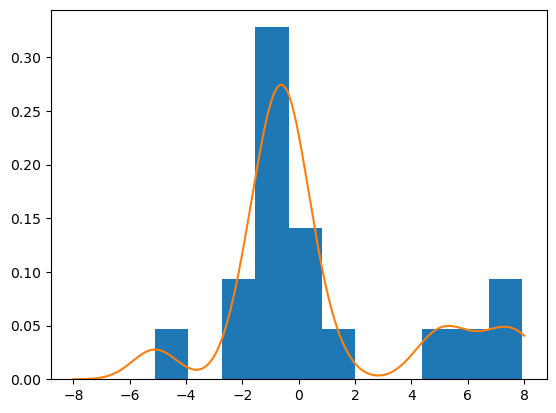

In [4]:
# parameters for fitting the KDE
dv_ub = 8.  # upper bound for fitting kde
dv_lb = -8.  # lower bound for fitting kde
dv_bandwidth = 0.8  # this is finicky
kernel_type = 'gaussian'  # use gaussian kernel

# setting up the values
values_dv = np.linspace(dv_lb, dv_ub, int(1e4))
kde_dv = np.array(dv).reshape((len(dv), 1))
kde_values_dv = values_dv.reshape(len(values_dv), 1)

# doing the KDE fit
kde_model_dv = KernelDensity(bandwidth=dv_bandwidth, kernel=kernel_type)
kde_model_dv.fit(kde_dv)

# plotting the KDE
plt.hist(dv, density=True, bins='auto')
plt.plot(kde_values_dv, np.exp(kde_model_dv.score_samples(kde_values_dv)))  # np.exp because sklearn returns score samples as log

Log-radiant uncertainty:

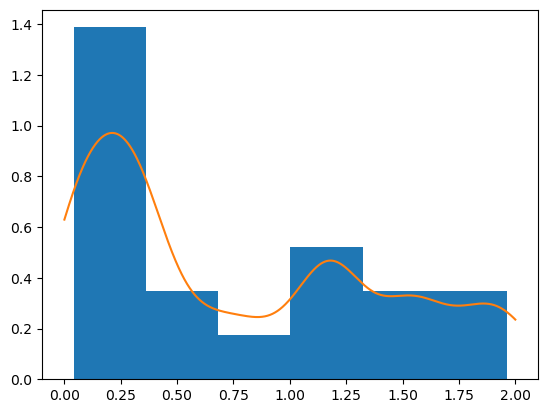

In [5]:
# parameters for the KDE fitting
drad_lb = 0.  # upper bound for fitting kde
drad_ub = 2.  # lower bound for fitting kde
log_drad_bandwidth = 0.15  # this is finicky

# setting up the values
log_drad = np.log10(drad)  # convert to log
values_drad = np.linspace(drad_lb, drad_ub, int(1e4))
kde_log_drad = np.array(log_drad).reshape((len(log_drad), 1))
kde_values_log_drad = values_drad.reshape(len(values_drad), 1)

# kde fit
kde_model_log_drad = KernelDensity(bandwidth=log_drad_bandwidth, kernel=kernel_type)  # use the same kernel as for the dv kde
kde_model_log_drad.fit(kde_log_drad)

# plot
plt.hist(log_drad, density=True, bins='auto')
plt.plot(kde_values_log_drad, np.exp(kde_model_log_drad.score_samples(kde_values_log_drad)))  # np.exp because sklearn returns score samples as log

Reading in the `.csv` file containing the decameter impactors:

In [6]:
# we define decameter impactors to be between 7.5 and 25 meters in diameter
# range of sizes (diameter in meters) we consider to be in the decameter regime
decameter_lb = 7.5  # lower bound
decameter_ub = 25.  # upper bound

# read file containing all impactors, no need to define columns since pandas reads this fine
all_impactors = pd.read_csv('../JPL-website-Oct19-2022-ORBITS-radiants-wspeeds-decameter-impactors-GOOD (1)_EDITED.csv', header='infer')
# filtering to only include those of decameter size (diameter is within some size range)
decameter_impactors = all_impactors.loc[(decameter_lb < all_impactors['Diameter (rho = 1500 kgm-3)']) & 
                                        (all_impactors['Diameter (rho = 1500 kgm-3)'] < decameter_ub)]

Now we want to convert the state vectors for the $100$ Monte Carlo samples of each decameter impact event. We first take $100$ Monte Carlo samples using the KDEs defined earlier. The state vectors we use are:
- Velocity
- Time of observation
- Latitude
- Longitude
- Elevation
- Azimuth
- Altitude
  
with random velocity errors added that we draw from our KDE for the velocity uncertainty earlier. The state vectors are then converted 
into orbital elements $\left(a, e, i, \Omega, \omega, M\right)$ (semi-major axis, eccentricity, inclination, longitude of ascending node, argument of pericenter, mean anomaly)  using `WMPL`.


KDE for the radiant uncertainty is drawn over $\log_{10}$-radiant uncertainty

First get the state vectors for all the events:

In [7]:
# state vectors
state_vector_list = ['Speed', 'Time', 'Latitude Numerical', 'Longitude Numerical', 'Altitude(km)', 'Zenith Distance', 'Radiant azimuth']
# drops the events that don't have the required information, and reset the index
impactor_state_vectors = decameter_impactors[state_vector_list].dropna().reset_index(drop=True)
# convert time to datetime format
impactor_state_vectors['Time'] = pd.to_datetime(impactor_state_vectors['Time'], format='mixed')
# convert every column other than time to numeric
impactor_state_vectors[impactor_state_vectors.columns[impactor_state_vectors.columns != 'Time']] = impactor_state_vectors[impactor_state_vectors.columns[impactor_state_vectors.columns != 'Time']].apply(pd.to_numeric, errors='coerce', axis=1)
# convert time to the format that wmpl takes in, '%Y%m%d-%H%M%S.%f'
impactor_state_vectors['Time'] = impactor_state_vectors['Time'].dt.strftime('%Y%m%d-%H%M%S.%f')

Then for each event, get $1000$ Monte Carlo samples, compute the orbital parameters for each Monte Carlo samples, and save it to an array:

Defining the `get_orbital_parameters` function to be used for computing orbital parameters from the state vector parameters -- this should be run in the `wmpl` conda environment or any environment with the `wmpl.Trajectory.Orbit` module active:

**NOTE**: sometimes wmpl.Trajectory.Orbit doesn't return the orbital elements? For example the command: 

`python3 -m wmpl.Trajectory.Orbit -v 9.542999528129108 -t '20130430-084000.000000' -a 35.5 -o -30.7 -e 21.2 --azim 297.7709815 --alt 39.50375116 --vrotcorr --statfixed` 

doesn't return orbital elements

In [8]:
import subprocess

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# number of Monte Carlo samples for each event
n_monte_carlo_samples = 1000

### HELPER FUNCTION to get the zenith/azimuth from the radiant uncertainty
def get_zen_azim_diff(zen, azim, theta, n_samples):
    """
    Get n_samples random new radiants that are a fixed angle theta away from the radiant given by (zen, azim) in 3D
    Note that zenith angle is 90 degrees - azimuth angle

    param zen: zenith angle, in degrees
    param azim: azimuth angle, in degrees
    param theta: angle from radiant that we want our new radiants to be, in degrees
    param n_samples: number of new radiants we want

    return zen_diff, azim_diff: tuple of arrays of floats of size n_samples each: 
    zen_diff and azim_diff are the new randomly generated radiant zenith/azimuth minus the given radiant zenith/azimuth
    """
    new_zens_deg = np.array([np.nan])  # initialize this to get the while loop started

    # this is a while loop to reject any zenith distance above 90 or below 0:
    while not np.all((new_zens_deg > 0) & (new_zens_deg < 90)):
        phis = np.random.uniform(0, 2 * np.pi, size=n_samples)  # these are the random directions we want our radiants to be in

        # convert zenith and azimuth into cartesian coordinates x, y, z
        v1 = np.array([np.sin(np.deg2rad(zen)) * np.cos(np.deg2rad(azim)), 
                       np.sin(np.deg2rad(zen)) * np.sin(np.deg2rad(azim)), 
                       np.cos(np.deg2rad(zen))])
        # get random new normalized vectors that are an angle theta away from v1, following the procedure described here:
        # https://math.stackexchange.com/questions/2057315/parameterising-all-vectors-a-fixed-angle-from-another-vector-in-3d
        # standard basis vector to use for generating orthonormal basis
        standard_basis_vec = np.array([1, 0, 0]) 
        # generate two basis vectors orthonormal to v1
        # normalize v1 in case it isn't already
        v1_normed = v1/np.linalg.norm(v1)
        # generate v2
        v2 = np.cross(v1_normed, standard_basis_vec)
        # normalize it
        v2_normed = v2/np.linalg.norm(v2)
        # generate a normalized v3 from the normalized v1 and v2
        v3_normed = np.cross(v1_normed, v2_normed)
        # now generate new vectors with radiant difference scattered by phis using vectorized operations
        new_radiants = v1_normed + np.tan(np.deg2rad(theta)) * (np.multiply.outer(np.cos(phis), v2_normed) + 
                                                                np.multiply.outer(np.sin(phis), v3_normed))
        # normalize the new vectors
        new_radiants_normed = new_radiants/np.linalg.norm(new_radiants, axis=1).reshape(-1, 1)
        # convert from cartesian coordinates back to zenith/azimuth coordinates
        xs, ys, zs = new_radiants_normed.T
        # get zeniths from cartesian
        new_zens = np.arccos(zs)
        # get azimuths from cartesian
        new_azims = np.arcsin(ys/np.sin(new_zens))
        # convert to degrees
        new_zens_deg = np.rad2deg(new_zens)
        new_azims_deg = np.rad2deg(new_azims)
        # first, manually convert the azimuths to the right quadrant since they can range from [0, 2pi] while zeniths can only be [0, pi/2]
        # Q1
        if 0. <= azim <= 90.:
            new_azims_deg = new_azims_deg  # already correct
        # Q2 and Q3:
        if 90. < azim <= 270.:
            new_azims_deg = np.abs(new_azims_deg - 180.)  # convert 
        # Q4:
        if 270. < azim <= 360.:
            new_azims_deg += 360  # convert
        
        # # finally, convert any negative azimuths back to [0, 360] degrees by adding 360 to any values less than 0
        # new_azims_deg += 360 * (new_azims_deg < 0)
        # # and convert any azimuths above 360 back down to [0, 360] as well
        # new_azims_deg = np.mod(new_azims_deg, 360)
            
    # return zenith and azimuth difference
    return new_zens_deg - zen, new_azims_deg - azim


# draw a monte carlo sample and get the orbital parameters using WMPL
def get_monte_carlo_orbital_parameters(kdes_state_vector_params, orb_param_variables=orb_param_variables):
    """
    Samples a Monte Carlo sample from provided KDEs for speed and radiant difference, and gets 
    the orbital parameter values corresponding to each parameter in orb_param_variables from the state vector state_vector
    
    param kdes_state_vector_params: tuple of (dv_kde, drad_kde, v, t, a, o, e, azim, alt):
    dv_kde is the speed uncertainty kde: should be a scikit-learn KernelDensity object
    log_drad_kde is the log10-radiant uncertainty kde: should be a scikit-learn KernelDensity object
    v is the velocity in km/s
    t is the time of the event in the form that the wmpl.Trajectory.Orbit function takes in, '%Y%m%d-%H%M%S.%f'
    a is the latitude, in degrees N
    o is the longitude, in degrees E
    e is the elevation of the event, in km
    azim is the radiant azimuth, in degrees
    zen is the zenith distance (90 minus the altitude angle), in degrees

    returns a 1-D array of parameter values corresponding to the parameters in orb_param_variables, in the same order
    """
    orb_param_array = np.array([])  # initialize orb_param_array as empty array so it doesn't have a size to start

    # unpack kdes and state_vector_params
    dv_kde, log_drad_kde, v, t, a, o, e, azim, zen = kdes_state_vector_params  # get the kdes and state vector parameters
    # converting from zenith angle to altitude angle
    alt = 90 - zen
    
    #### THIS IS A WHILE LOOP AS A SAFEGUARD BECAUSE IT SEEMS LIKE SOMETIMES WMPL DOESN'T RETURN THE ORBITAL ELEMENTS AT ALL
    # so if orbital parameter array is empty (no orbital elements returned) then we repeat this
    while not orb_param_array.size:
        np.random.seed(None)  # explicitly reset the seed since the sampler for sklearn doesn't seem to be sampling randomly otherwise
        # get monte carlo sample of the speed and log-radiant uncertainty
        dv = dv_kde.sample(n_samples=1).flatten()  # get a single dv mc sample
        log_drad = log_drad_kde.sample(n_samples=1).flatten()  # get a single log drad mc sample

        # convert the log-radiant uncertainty into zenith and azimuth uncertainty using the helper function
        # with the restrictions that zenith must be between [0, 90] degrees
        dzen, dazim = get_zen_azim_diff(zen, azim, 10 ** log_drad, n_samples=1)  # log10-radiant so convert back to radiant
        # difference in altitude is negative of difference in zenith since it's 90 - zenith
        # so zen1 - zen2 = (90 - alt1) - (90 - alt2) = alt2 - alt1
        dalt = -dzen
        # adding the uncertainty in velocity to the velocity vector of the event
        # and adding the uncertainty in zenith angle and azimuth angle to the radiant
        # convert the singleton arrays to floats as well
        new_v = v + dv[0]
        new_alt = alt + dalt[0]
        # azimuth is modulo 360 to keep it between 0 and 360 degrees
        new_azim = (azim + dazim[0]) % 360
        # get the output from the wmpl.Trajectory.Orbit script
        output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{new_v}', '-t', f'{t}', '-a', f'{a}', 
                                 '-o', f'{o}', '-e', f'{e}', '--azim', f'{new_azim}', '--alt', f'{new_alt}', 
                                 '--vrotcorr', '--statfixed'], capture_output=True)
        # get the orbital parameters from the output in the order of orb_param_variables
        
        # orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
        #               if elem.startswith(tuple(orb_param_variables))]
        # orb_param_array = [np.float64(string) for param in orb_param_list 
        #                    for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan']]
        
        orb_param_array = np.array([np.float64(string) for param in [elem for elem in 
                                                                     list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                                     if elem.startswith(tuple(orb_param_variables))] 
                                    for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])
    
    # return the orbital parameter array
    return orb_param_array

Optional: Computing orbital parameters from state vector parameters using multiprocessing -- skip this cell if already have the orbital parameters saved as a `.npy` or something

In [9]:
# import multiprocessing

# # initialize array for orbital parameters for all the events with the shape 
# # (number of impact events, number of monte carlo samples per event, number of orbital parameters per monte carlo sample)
# orb_param_array_all_events = np.zeros((len(impactor_state_vectors), n_monte_carlo_samples, len(orb_param_variables)))

# # compute orbital parameters of Monte Carlo samples for each event in the decameter impactors table
# for i, event in impactor_state_vectors.iterrows():
    
#     # get the state vectors to input into the wmpl.Trajectory.Orbit file
#     v = event['Speed']
#     t = event['Time']
#     a = event['Latitude Numerical']
#     o = event['Longitude Numerical']
#     e = event['Altitude(km)']
#     azim = event['Radiant azimuth']
#     # zenith distance, note that altitude is 90 minus the zenith distance! 
#     zen = event['Zenith Distance']  # this is converted to alt in the get_monte_carlo_orbital_parameters function

#     # create parameter list for multiprocessing for a number of Monte Carlo samples equal to n_monte_carlo_samples
#     state_vector_par_list = np.repeat([[kde_model_dv, kde_model_log_drad, v, t, a, o, e, azim, zen]], n_monte_carlo_samples, axis=0)    
#     # now compute the orbital parameters from the state vectors for each Monte Carlo sample, using multiprocessing:
#     pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
#     # get the array of orbital parameters for all the monte carlo samples of this single event, using multiprocessing
#     orb_param_array_single_event = np.asarray(list(tqdm(pool.imap(get_monte_carlo_orbital_parameters, state_vector_par_list))))
#     # add the orb param array for this single event to the orbital parameter array for all events
#     orb_param_array_all_events[i] = orb_param_array_single_event

Optional: Save the file as a numpy array

In [10]:
# np.save('orb_params_all_events_mc.npy', orb_param_array_all_events)  # save as a .npy file

Optional: Read in `.npy` file for all the orbital parameters if haven't already run the multiprocessing code:

In [11]:
orb_param_array_all_events = np.load('orb_params_all_events_mc.npy')  # get the orbital parameters

Plotting distribution of semi-major axis for these events vs. the "true" value as a test to see if the pipeline is working as we expect:

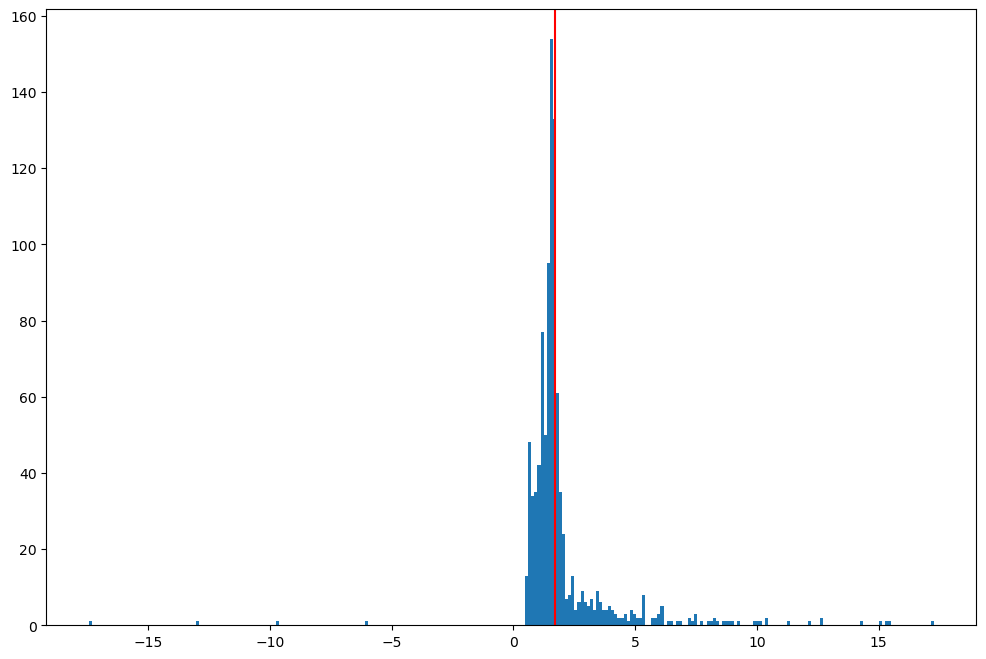

(1.7126588, 1.572441)

In [12]:
# get "true" semi-major axes from the sheet
true_smas = decameter_impactors['a'].dropna().reset_index(drop=True)
# get mc'ed semi-major axes
event_ind = 0  # index of the event to check

# filter outliers to make the histogram a bit easier to see
outlier_lb = -20  # define these to be the bounds for the histogram
outlier_ub = 20
filtered_array = orb_param_array_all_events[event_ind, :, 0][(orb_param_array_all_events[event_ind, :, 0] 
                                                              < outlier_ub) & (orb_param_array_all_events[event_ind, :, 0] 
                                                                               > outlier_lb)]

# plot everything
plt.figure(figsize = (12, 8))
# plot distribution of semi-major axis for all the Monte Carlo clones compared to the "true" value
plt.hist(filtered_array, bins='auto')  # plot histogram
# plot true value
plt.axvline(true_smas[event_ind], c='r')
plt.show()
# true semi major axis and median value of our 100 Monte Carlo samples, ignoring the unphysical negative semi major axes
true_smas[event_ind], np.median(filtered_array[filtered_array > 0])

Now get the $a$, $e$, $i$ values for all the events:

In [13]:
# getting the indices for a, e and i in the orbital parameters array (should be the same order as in orb_param_variables)
a_index = orb_param_variables.index('a')
e_index = orb_param_variables.index('e')
i_index = orb_param_variables.index('i')

# these will have the shape (number of events, number of Monte Carlo simulations, 3)
mc_aeis = orb_param_array_all_events[:, :, [a_index, e_index, i_index]]

Now reading in the `.dat` file for the Granvik model. The directory `granvik-model` should be in the same directory as this notebook.

**NOTES**:
1. Get the model from the dropbox if you want to use locally!
2. The line $\left(a, e, i, H\right)$ = $\left(2.350, 0.980, 170.000, 15.605\right)$ in the `gmb_model.dat` and `gmb_model-noheader.dat` files has a typo; should be $15.625$ in place of $15.605$

In [14]:
# defining the granvik columns manually 
# (could figure out how to get pandas to read this automatically in the dat file that actually has headers)
granvik_columns = ['sma', 'ecc', 'inc', 'Hmag', 'number', 'rel_dnumber', 
                   'nu6_prob', '5/2_prob', '2/1_prob', 'HUN_prob', '3/1_prob', 'PHO_prob', 'JFC_prob', 
                   'nu6_sigma', '5/2_sigma', '2/1_sigma', 'HUN_sigma', '3/1_sigma', 'PHO_sigma', 'JFC_sigma', 
                   'pv<0.1', '0.1<pv<0.3', 'sig', 'albedo_cat', 'collprob', 'MOID']

# read in the granvik file
granvik_model = pd.read_csv('granvik-model/gmb_model-noheader.dat', delim_whitespace=True, 
                            skip_blank_lines=True, header=None, float_precision='high')
granvik_model.columns = granvik_columns  # columns

Add $H$ from the Granvik model file to the $a$, $e$, $i$s as well. We take it to be the maximum magnitude (dimmest objects) in the Granvik model (so largest $H$), which should be $24.875$:

In [15]:
# use the maximum magnitude in the granvik model file, it's really good that it is actually uniformly sampled in H
H = np.max(granvik_model['Hmag'])
# concatenate the aies with the h values so we have AEI and H:
mc_aeihs = np.concatenate((mc_aeis, np.ones((mc_aeis.shape[0], mc_aeis.shape[1], 1)) * H), axis=2)

Get the escape region probabilities (and the corresponding uncertainties due to model degeneracy) and the $a$, $e$, $i$, $H$ values from the Granvik model:

In [16]:
# escape region probabilities and sigmas
er_prob_sigma_params = ['nu6_prob', '5/2_prob', '2/1_prob', 'HUN_prob', '3/1_prob', 'PHO_prob', 'JFC_prob', 
                        'nu6_sigma', '5/2_sigma', '2/1_sigma', 'HUN_sigma', '3/1_sigma', 'PHO_sigma', 'JFC_sigma']
er_probs_sigmas = granvik_model[er_prob_sigma_params]

# a, e, i, H values
granvik_params = ['sma', 'ecc', 'inc', 'Hmag']
granvik_aeihs = granvik_model[granvik_params]

Interpolate the Granvik file for intermediate values of the parameter space; try interpolation with nearest-neighbours, linear radial basis function and rectilinear grid with cubic splines:

First try using basic nearest-neighbours interpolation in $N$ dimensions (this is fastest and runs into the fewest problems but is also probably less accurate):

In [17]:
# interpolated probabilities/sigmas drawn from the granvik model
# with the shape (number of escape region probabilities/sigmas, number of events, number of MC samples)
interp_probs_nn = np.zeros((len(er_probs_sigmas.columns), len(impactor_state_vectors), n_monte_carlo_samples))

# perform the interpolation
for i, column in tqdm(enumerate(er_probs_sigmas.columns)):
    # build the interpolator for each escape region probability/sigma
    # rescale since the data aren't evenly sampled and the scales are different for all of them
    nn_interpolator = scipy.interpolate.NearestNDInterpolator(np.array(granvik_aeihs), np.array(er_probs_sigmas[column]), rescale=True)
    # now interpolate every event
    # print(column)
    for j, event_samples in enumerate(mc_aeihs):
        # event_samples is (number of mc samples, 4) array of all the MC samples for a given even
        # print(event_samples)

        # convert nan to 0 inplace (this is just a placeholder until I figure out what to do with the nan values later
        # as nearest neighbour interpolation doesn't like nans
        np.nan_to_num(event_samples, copy=False, nan=0.)

        # print(nn_interpolator(event_samples))
        # perform the interpolation
        interp_probs_nn[i, j] = nn_interpolator(event_samples)

14it [00:03,  4.02it/s]


Try with linear radial basis function (cubic spline/thin plate spline doesn't work because of repeat values):

In [18]:
# rbf_kernel = 'linear'  # cubic gives singular matrix because of repeat values, adding epsilon doesn't fix it either so go with linear

# # interpolated probabilities and sigmas drawn from the granvik model
# # with the shape (number of escape region probabilities/sigmas, number of events, number of MC samples)
# interp_probs_linear_rbf = np.zeros((len(er_probs_sigmas.columns), len(impactor_state_vectors), n_monte_carlo_samples))

# # nearest neighbours to perform interpolation with (don't need all of them since it's a huge file and also speeds it up by a lot
# n_neighbors = 1e3  # 5e3 takes like 5 minutes per escape region, 1e3 takes about 8-10 seconds per escape region

# # perform the interpolation
# for i, column in tqdm(enumerate(er_probs_sigmas.columns)):
#     # build the interpolator for each escape region probability/sigma
#     # rescale since the data aren't evenly sampled and the scales are different for all of them
#     linear_rbf_interpolator = scipy.interpolate.RBFInterpolator(np.array(granvik_aeihs), np.array(er_probs_sigmas[column]), 
#                                                                 neighbors=n_neighbors, kernel=rbf_kernel)
#     # now interpolate every event
#     for j, event_samples in enumerate(mc_aeihs):
#         # event_samples is (number of mc samples, 4) array of all the MC samples for a given even
#         # print(event_samples)

#         # convert nan to 0 inplace (this is just a placeholder until I figure out what to do with the nan values later...)
#         # np.nan_to_num(event_samples, copy=False, nan=0.)
        
#         # perform the interpolation
#         interp_probs_linear_rbf[i, j] = linear_rbf_interpolator(event_samples)

Now try interpolating using a rectilinear grid with cubic splines:

Construct a rectilinear grid from the Granvik model using the bounds given in the file

In [19]:
rectgrid_method = 'cubic'  # use cubic splines for the rectilinear grid interpolation

# get the grid points in a, e, i, H from the granvik model
granvik_smas = np.sort(np.unique(granvik_aeihs['sma']))
granvik_eccs = np.sort(np.unique(granvik_aeihs['ecc']))
granvik_incs = np.sort(np.unique(granvik_aeihs['inc']))
granvik_Hs = np.sort(np.unique(granvik_aeihs['Hmag']))

# meshgrid to construct the rectilinear grid with
xx, yy, zz, ww = np.meshgrid(granvik_smas, granvik_eccs, granvik_incs, granvik_Hs)

# not sure why i need to switch i and j here in this list comprehension construction, but I do...
# this was an issue in summer 2023 as well actually

# constructing the 4-d rectilinear grid with bounds given by the granvik model
grid_df = pd.DataFrame(np.array([(xx[j, i, k, l], yy[j, i, k, l], zz[j, i, k, l], ww[j, i, k, l]) 
              for i in range(0, len(granvik_smas)) 
              for j in range(0, len(granvik_eccs)) 
              for k in range(0, len(granvik_incs)) 
              for l in range(0, len(granvik_Hs))]), columns = granvik_params)

Now use the probability/sigma from the granvik model if the grid point is in the file, and inpute $0$ if the grid point is not in the file:

In [20]:
# probabilities/sigmas for the rectilinear grid 
# use the probability/sigma from the granvik model if grid point is in the file
# otherwise impute 0 if the grid value is not in the granvik model file

# create dataframe with indicator of whether the grid point exists in the granvik model file as well
indicator_df = pd.merge(grid_df, granvik_aeihs, on=granvik_params, how='left', indicator='Exist')

# create array of escape region probabilities/sigmas with the shape (number of grid points, number of escape regions)
probs = np.zeros((len(grid_df), len(er_prob_sigma_params)))
# use probability from granvik model if the indicator notes that the grid point is in the granvik file, and leave it as 0 otherwise
probs[np.where(indicator_df['Exist'] == 'both')] = er_probs_sigmas
# create final dataframe with all grid points and corresponding escape region probabilities/sigmas
grid_probs = pd.concat((indicator_df, pd.DataFrame(probs, columns = er_prob_sigma_params)), axis=1)

Optional: Perform the rectilinear grid interpolation using cubic splines, iterating over every escape region probability/sigma -- skip this cell if the interpolated probabilities have been run and saved previously:

In [21]:
# # interpolated probabilities/sigmas drawn from the granvik model
# # with the shape (number of escape regions, number of events, number of MC samples)
# interp_probs_rectgrid_mc = np.zeros((len(er_probs_sigmas.columns), len(impactor_state_vectors), n_monte_carlo_samples))

# for i, column in tqdm(enumerate(er_probs_sigmas.columns)):
#     # get the probability/sigma for the given escape region
#     column_prob = np.array(grid_probs[column]).reshape(len(granvik_smas), len(granvik_eccs), len(granvik_incs), len(granvik_Hs))
#     # build the interpolator for the given escape region probability/sigma using cubic splines
#     # fill any values outside the grid with nans
#     rectgrid_interpolator_mc = scipy.interpolate.RegularGridInterpolator((granvik_smas, granvik_eccs, granvik_incs, granvik_Hs), column_prob, 
#                                                                       method=rectgrid_method, bounds_error=False, fill_value=np.nan)
#     # now interpolate all mc samples for every event
#     for j, event_samples in enumerate(mc_aeihs):
#         # event_samples is (number of mc samples, 4) array of all the MC samples for a given event
#         interp_probs_rectgrid_mc[i, j] = rectgrid_interpolator_mc(event_samples)                

Optional: Save the interpolated probabilities/sigmas as a `.npy` file:

In [22]:
# np.save('interp_probs_sigmas_mc.npy', interp_probs_rectgrid_mc)  # save as a .npy file

Optional: Read in `.npy` file for the probabilities/sigmas if haven't already run the interpolator:

In [23]:
interp_probs_rectgrid_mc = np.load('interp_probs_sigmas_mc.npy')  # get the interpolated probabilities/sigmas

Test interpolation of RBF w/ linear, NN, rectilinear grid w/ cubic spline for `nu6` probability for the first event's MC samples (should be chelyabinsk):

In [24]:
event_ind_interp_test = 0  # event to check
er = 'nu6_prob'  # escape region probability/sigma to check

# set up nu6_prob for rectgrid interpolator since it's different from the other interpolators
nu6_prob = np.array(grid_probs[er]).reshape(len(granvik_smas), len(granvik_eccs), len(granvik_incs), len(granvik_Hs))
rectgrid_interpolator_test = scipy.interpolate.RegularGridInterpolator((granvik_smas, granvik_eccs, granvik_incs, granvik_Hs), nu6_prob, 
                                          method=rectgrid_method, bounds_error=False, fill_value=np.nan)(mc_aeihs[event_ind_interp_test])
# nearestnd and rbf interpolators work fine like this
nearestnd_interpolator_test = scipy.interpolate.NearestNDInterpolator(np.array(granvik_aeihs), np.array(er_probs_sigmas[er]), 
                                                                      rescale=True)(mc_aeihs[event_ind_interp_test])
# rbf_interpolator_test = scipy.interpolate.RBFInterpolator(np.array(granvik_aeihs), np.array(er_probs_sigmas[er]), 
#                                                      neighbors=n_neighbors, kernel=rbf_kernel)(mc_aeihs[event_ind_interp_test])

In [25]:
rectgrid_interpolator_test, nearestnd_interpolator_test# , rbf_interpolator_test

(array([ 7.48224724e-01,  7.72076521e-01,             nan,  7.03290974e-01,
         7.62618926e-01,  7.69777532e-01,  7.62326562e-01,  9.56362672e-01,
         7.87883130e-01,             nan,  5.03911251e-01,             nan,
         4.06237464e-01,  8.03069320e-01,  7.84595832e-01,  7.26027944e-01,
         7.92277050e-01,  8.07825105e-01,             nan,  7.88173258e-01,
         7.79518255e-01,  7.83835689e-01,  7.82005099e-01,  7.38625688e-01,
                    nan,             nan,  6.95257674e-01,  7.56442252e-01,
         7.85014093e-01,  1.29652240e-01,  9.94697406e-02,  7.85299746e-01,
         2.13124400e-03,  7.87302246e-01,  7.29268807e-01,  7.34357898e-01,
         2.96606704e-02,  7.76362731e-01,  6.65063252e-01,  1.12988451e-01,
         7.20123847e-01,  7.47262439e-01,  7.58270532e-01,  7.79642350e-01,
         6.70032257e-01,  5.13123830e-01,             nan,             nan,
         7.37208918e-01,             nan,  7.96703743e-01,  8.03642663e-01,
         8.0

Plot the interpolated probabilities:

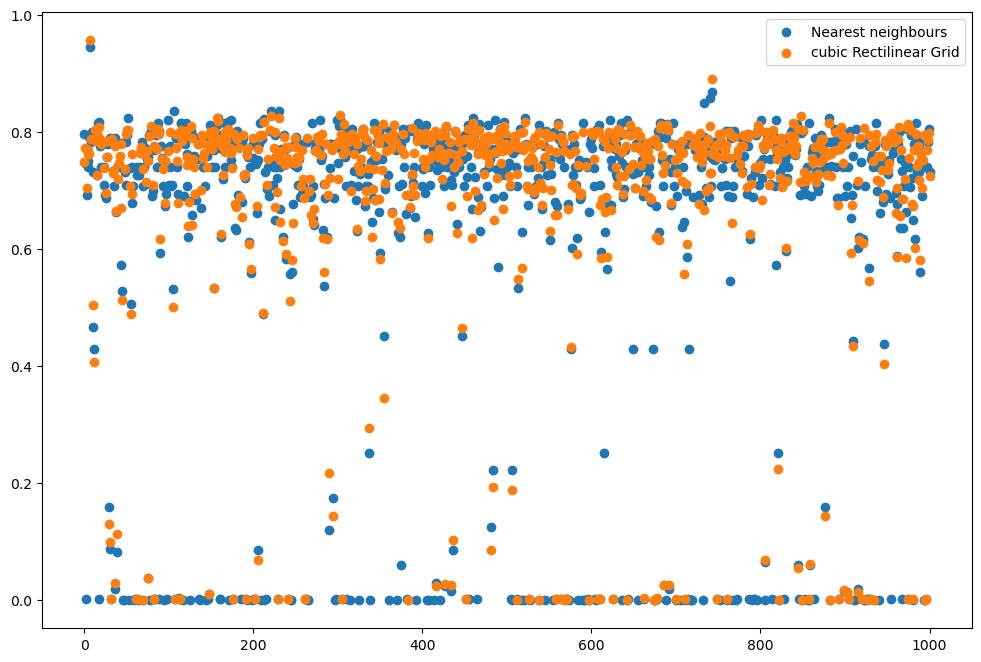

In [26]:
n_test_interp_pts = np.linspace(0, n_monte_carlo_samples, n_monte_carlo_samples)

plt.figure(figsize = (12, 8))
# plt.scatter(n_test_interp_pts, rbf_interpolator_test, label = f'{rbf_kernel} RBF')
plt.scatter(n_test_interp_pts, nearestnd_interpolator_test, label = 'Nearest neighbours')
plt.scatter(n_test_interp_pts, rectgrid_interpolator_test, label = f'{rectgrid_method} Rectilinear Grid')
plt.legend()

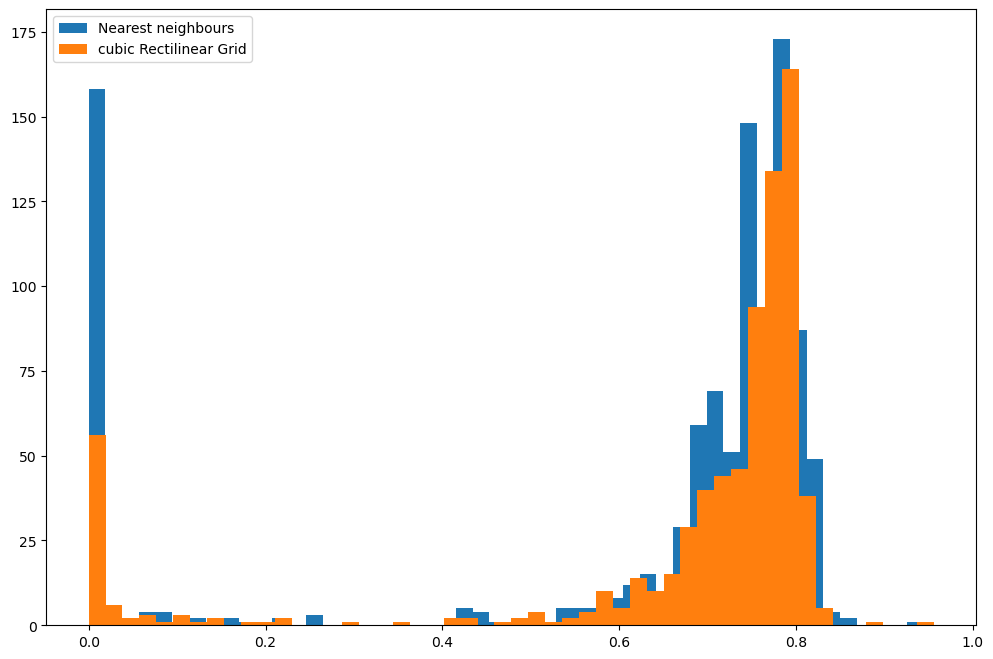

In [27]:
n_bins = 50  # number of bins

plt.figure(figsize = (12, 8))
# plt.hist(rbf_interpolator_test, bins='auto', label = f'{rbf_kernel} RBF')
# bins = 'auto' causes issues if the values are too disparate since there's too many bins I think
plt.hist(nearestnd_interpolator_test, bins=n_bins, label = 'Nearest neighbours')
plt.hist(rectgrid_interpolator_test, bins=n_bins, label = f'{rectgrid_method} Rectilinear Grid')
plt.legend()

All methods generally agree, RBF seems to like intermediate values more than nearestND and rectgrid though (although it's also probably the least accurate one)

In [28]:
# Linear N-dimensional Interpolation hangs
# scipy.interpolate.LinearNDInterpolator(np.array(granvik_aeihs), np.array(er_probs_sigmas['nu6_prob']), fill_value=np.nan, rescale=True)

Plot the interpolated probabilities and sigmas from the rectilinear grid cubic spline method for all $7$ escape regions for every event on the same plot, and save the figures:

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:25<00:00,  1.83s/it]


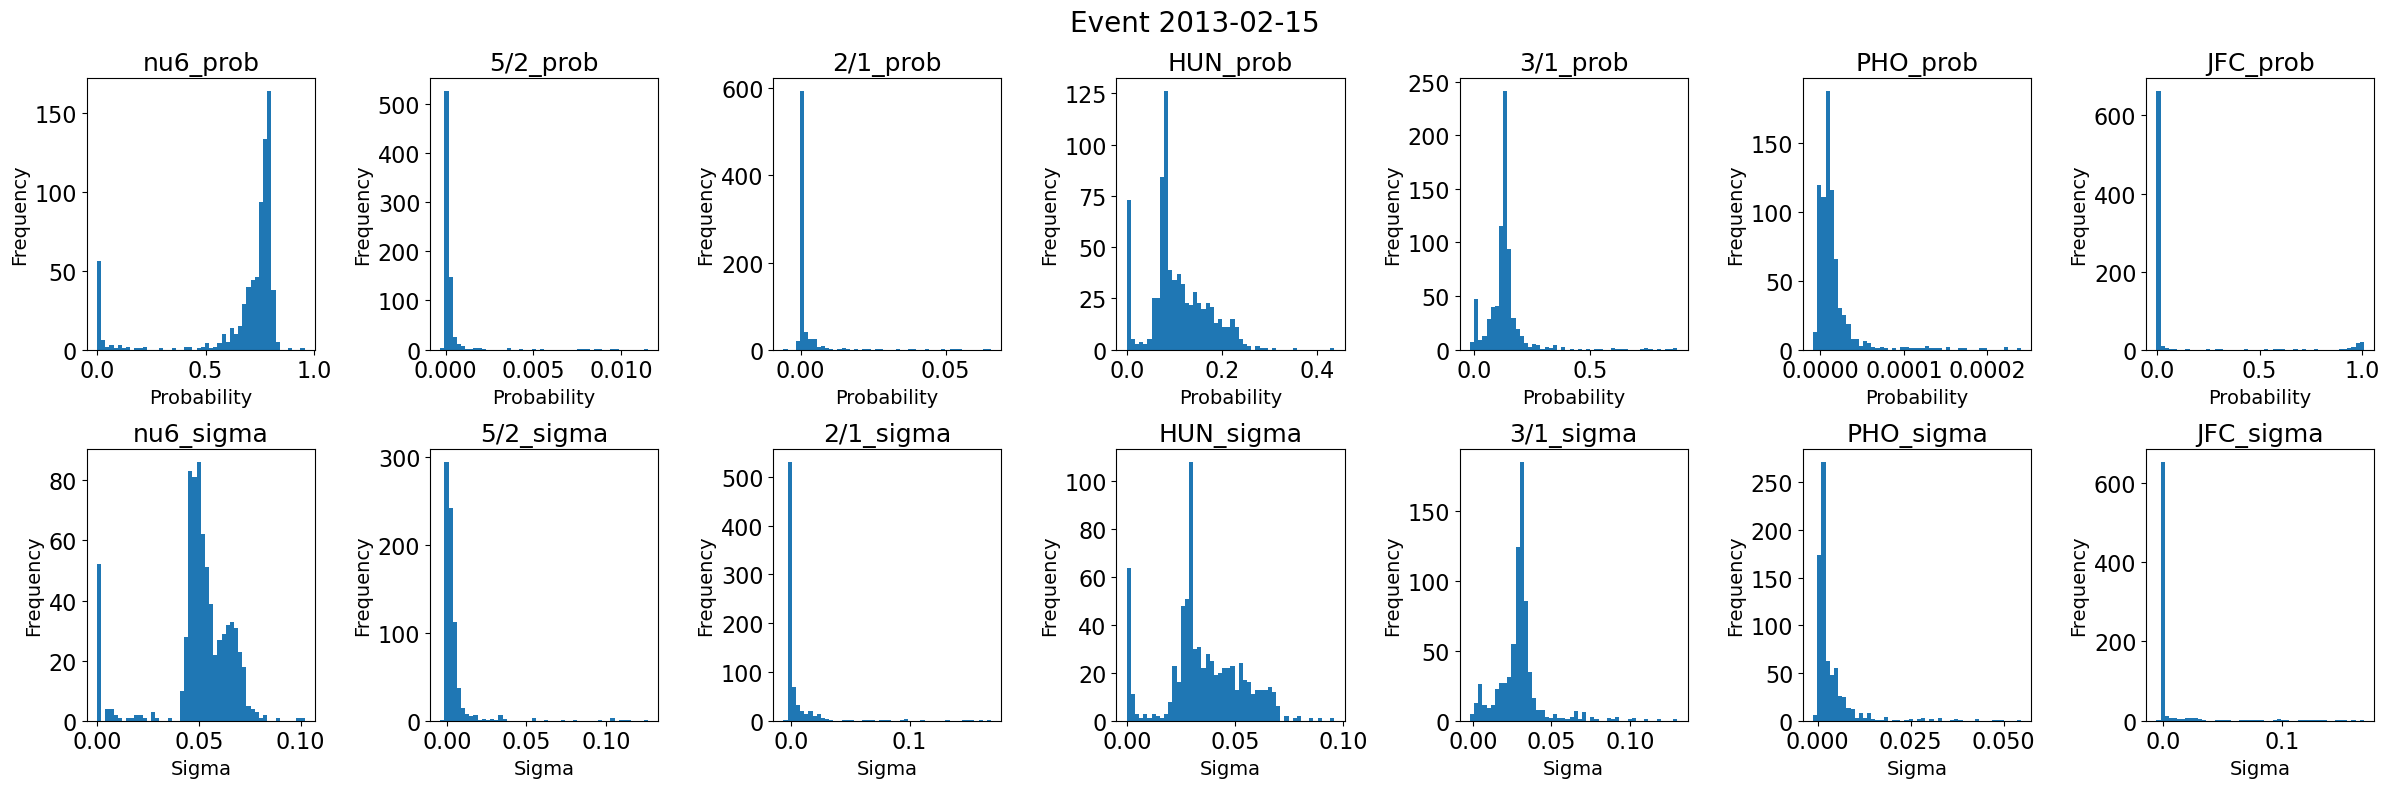

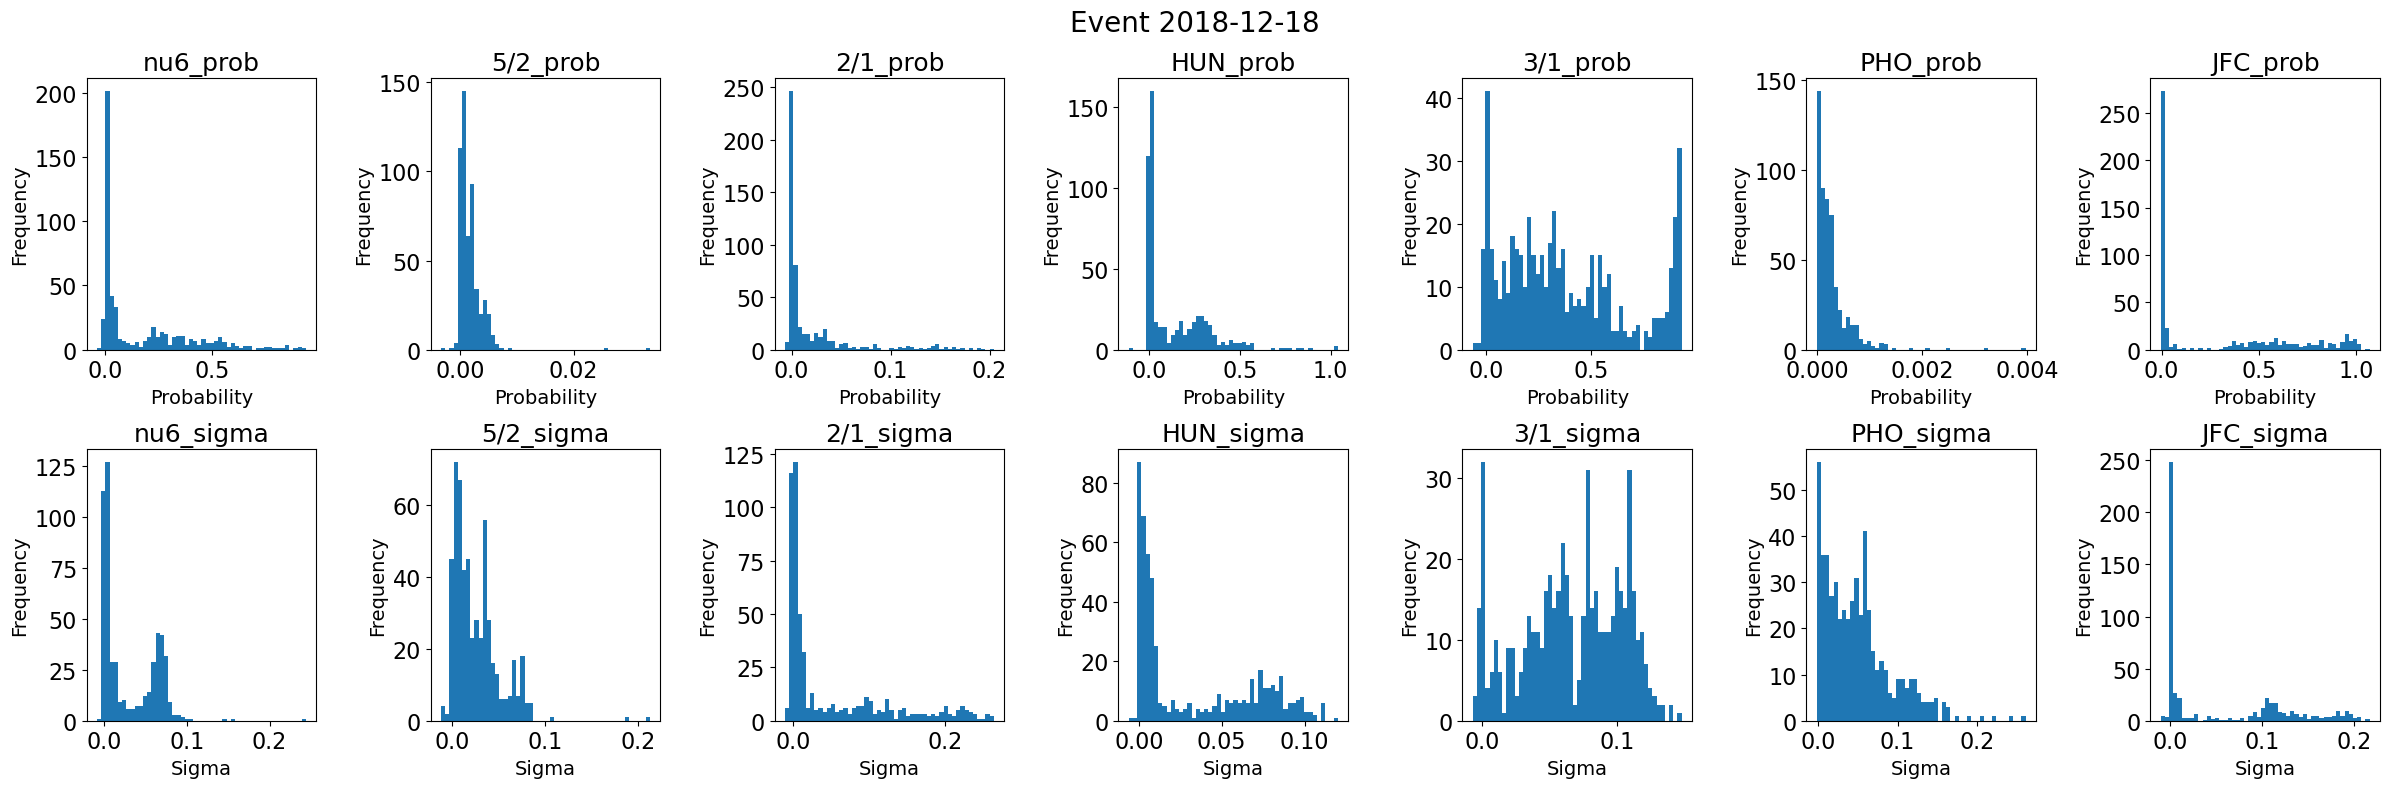

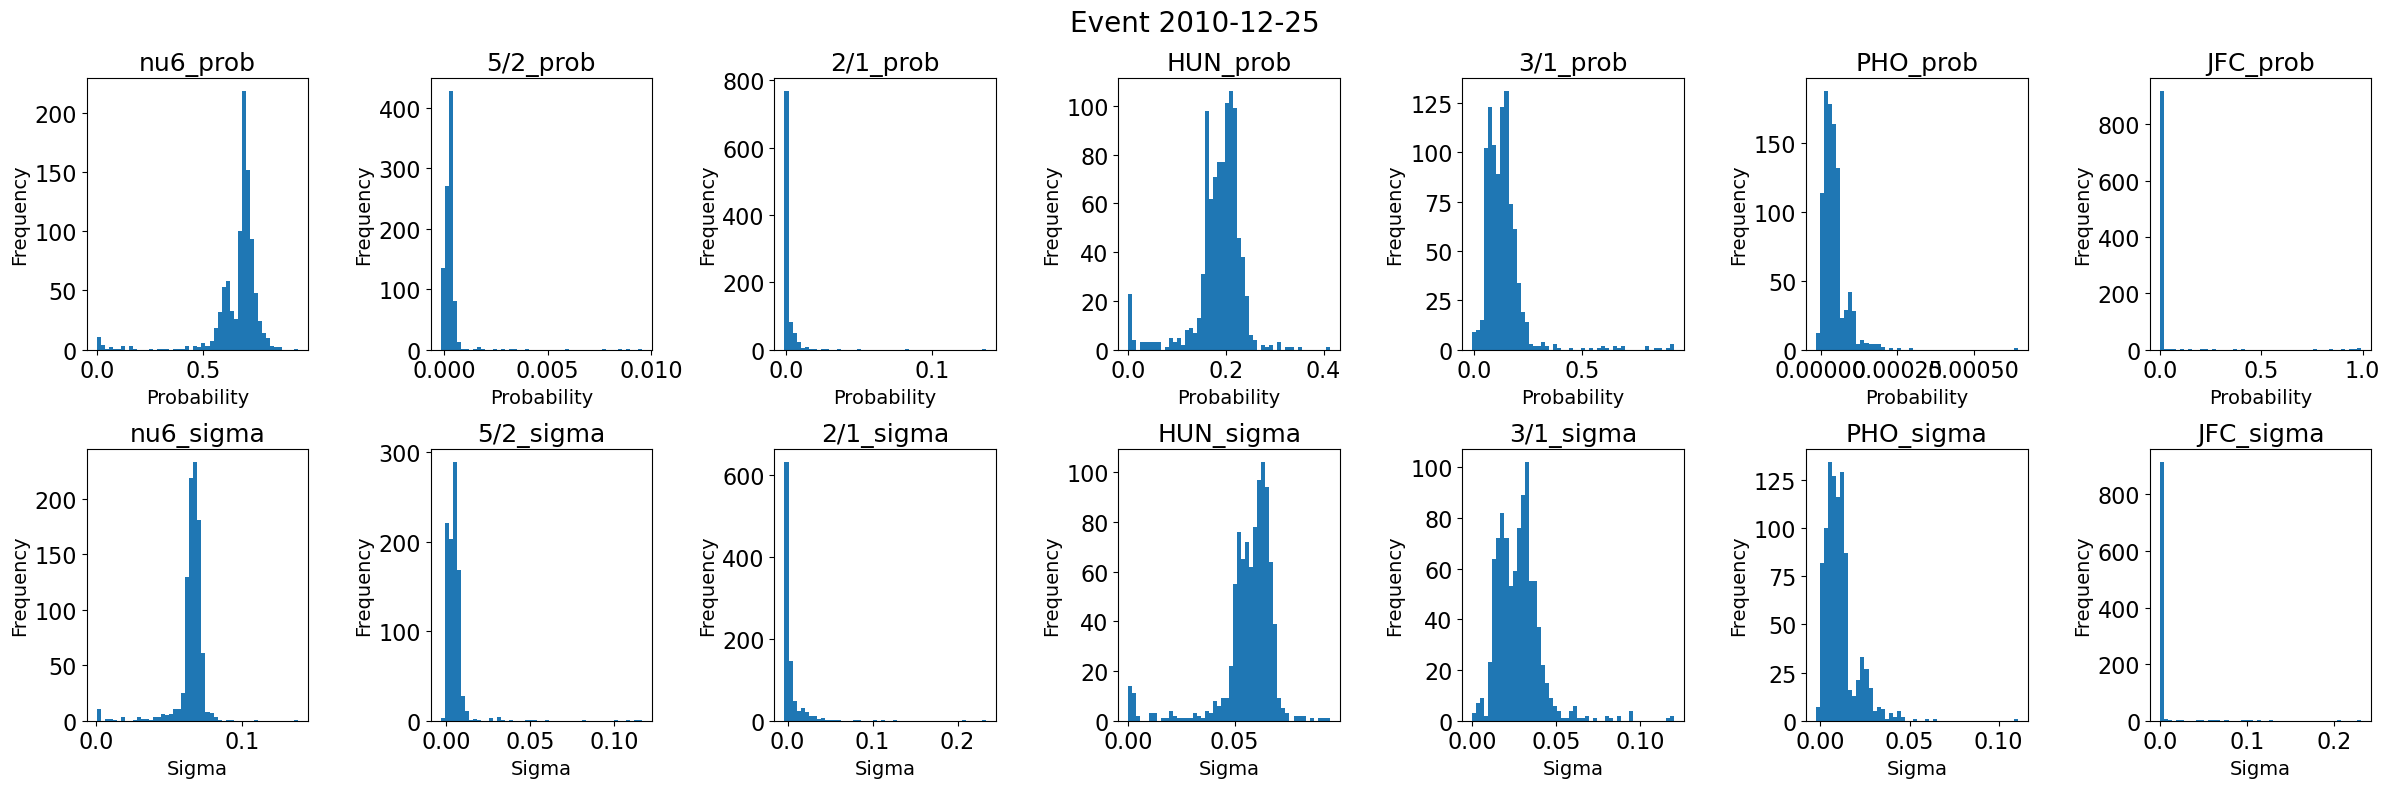

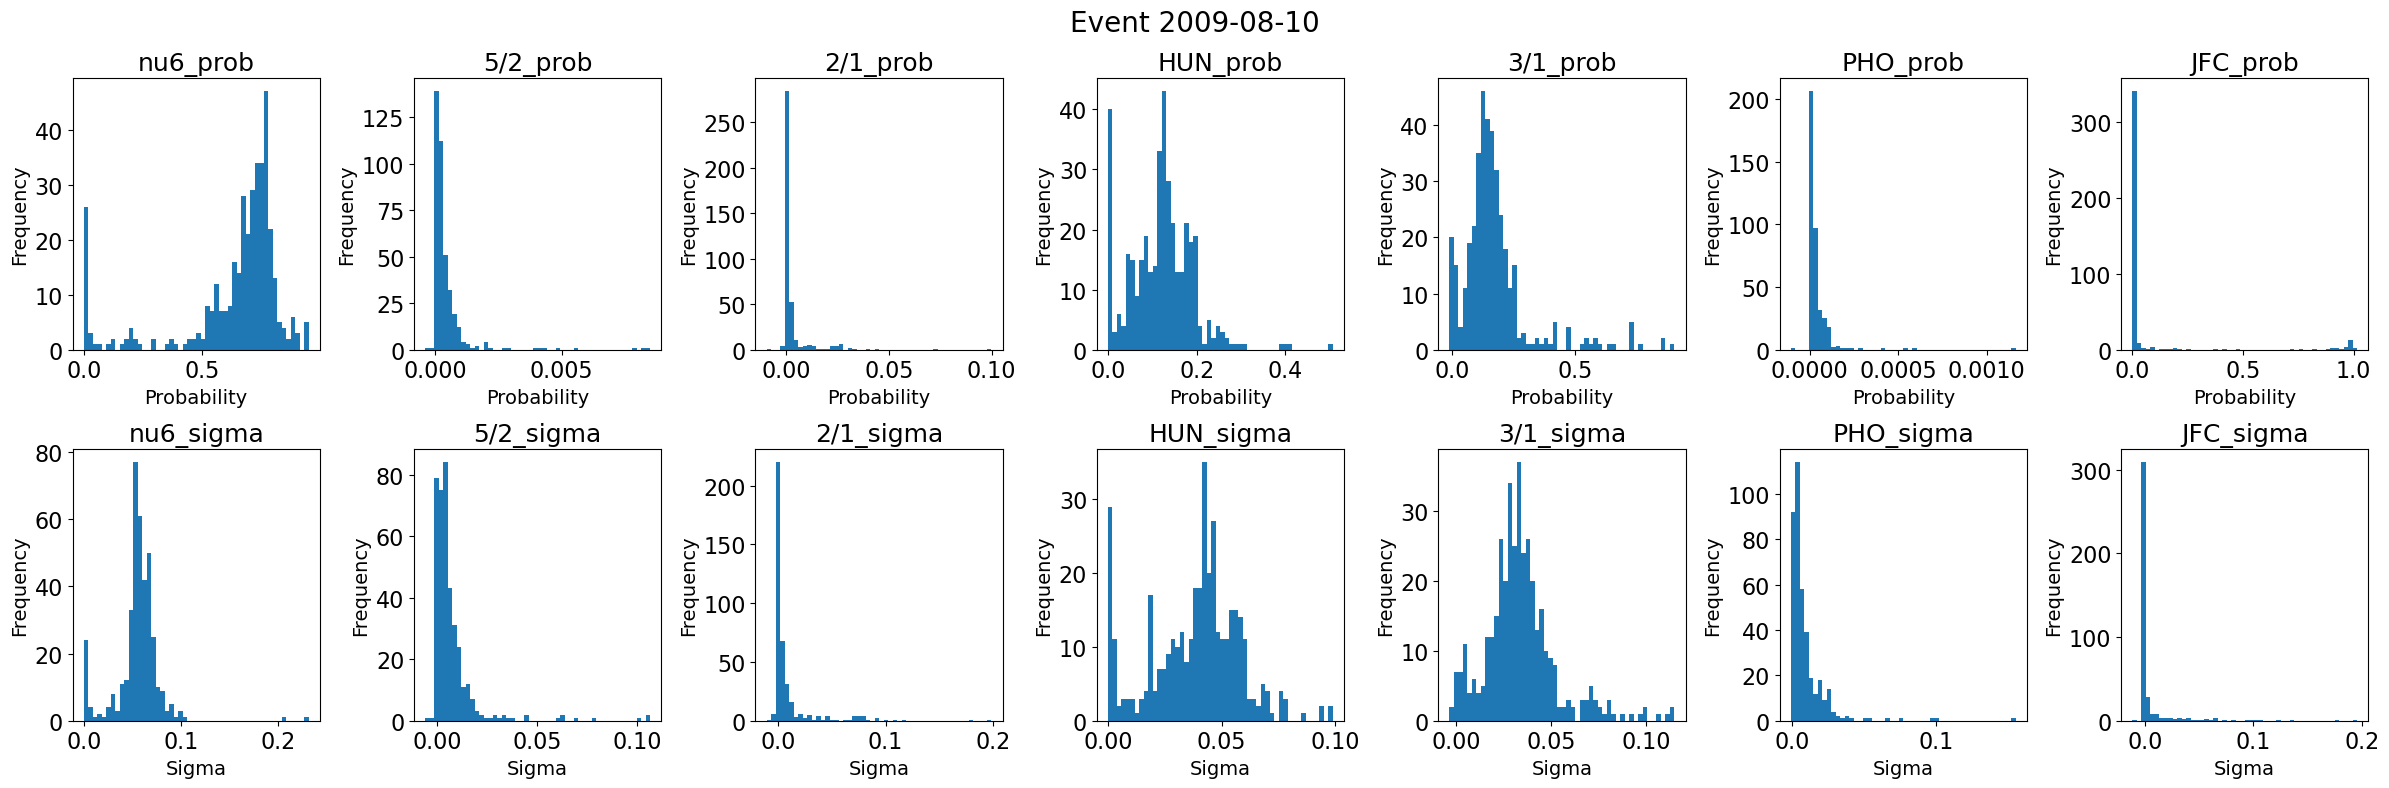

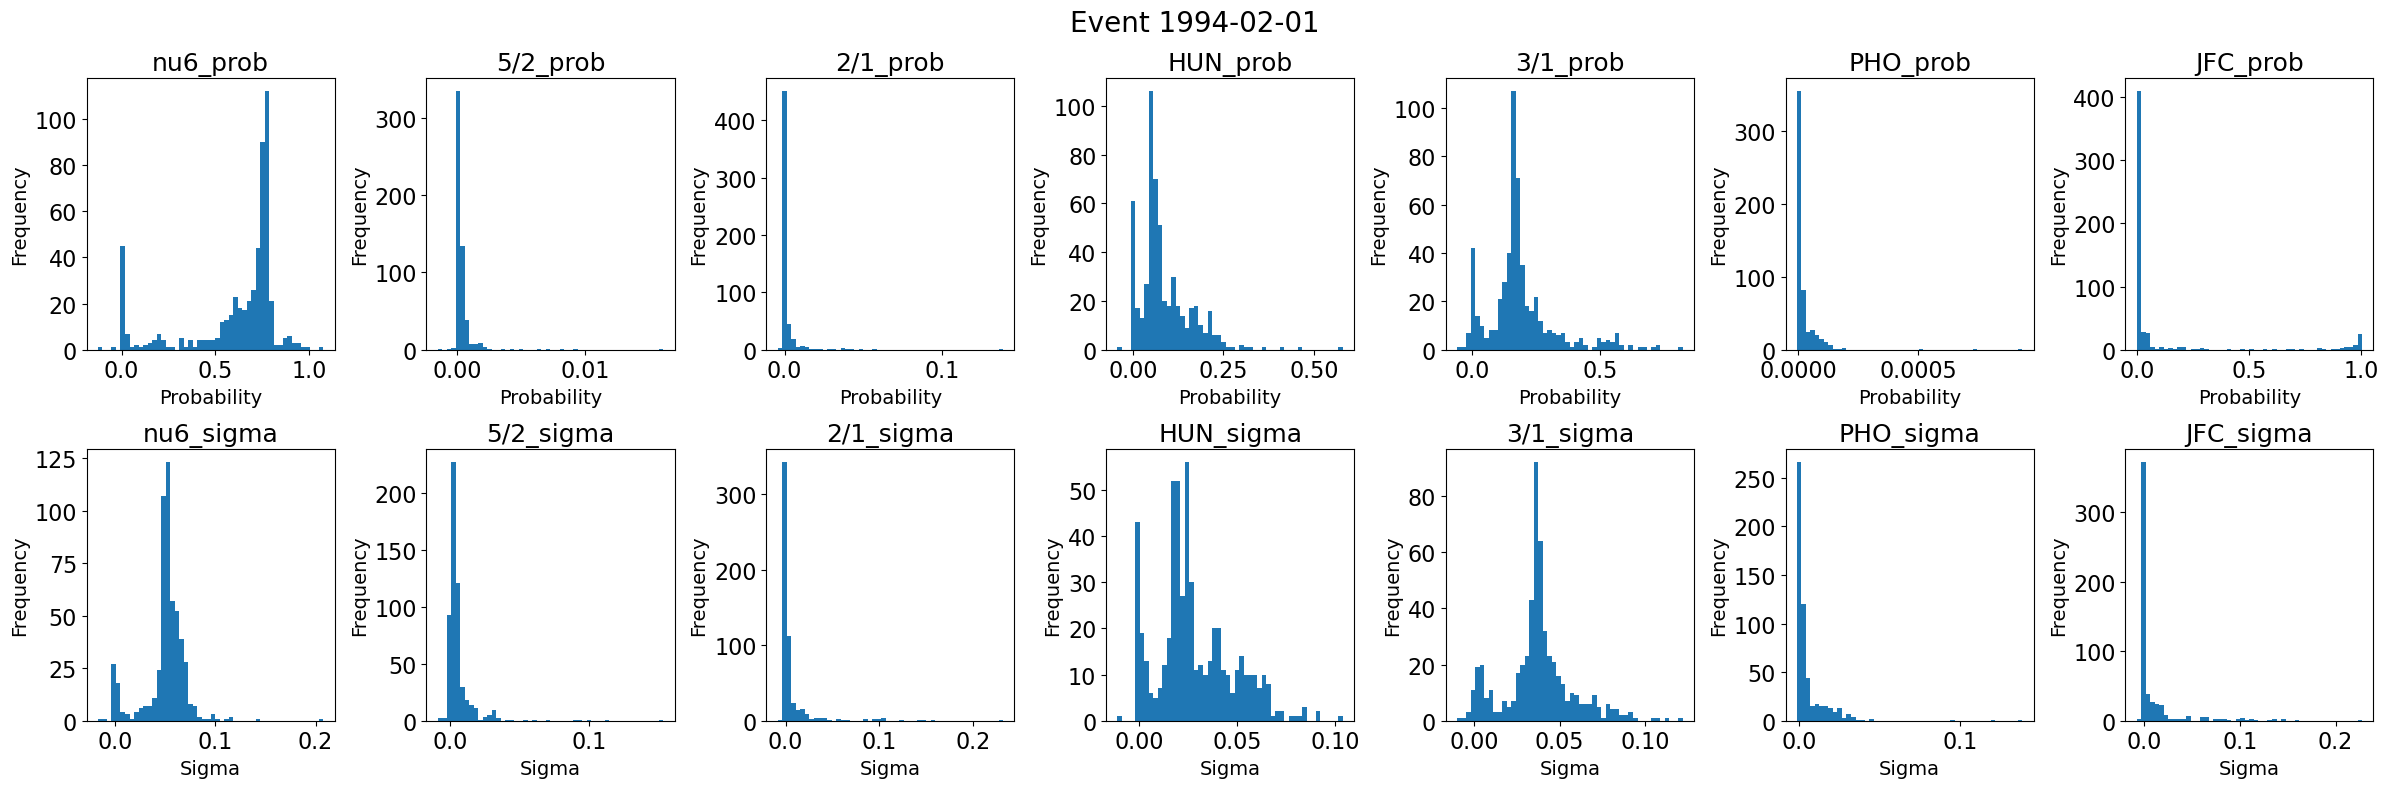

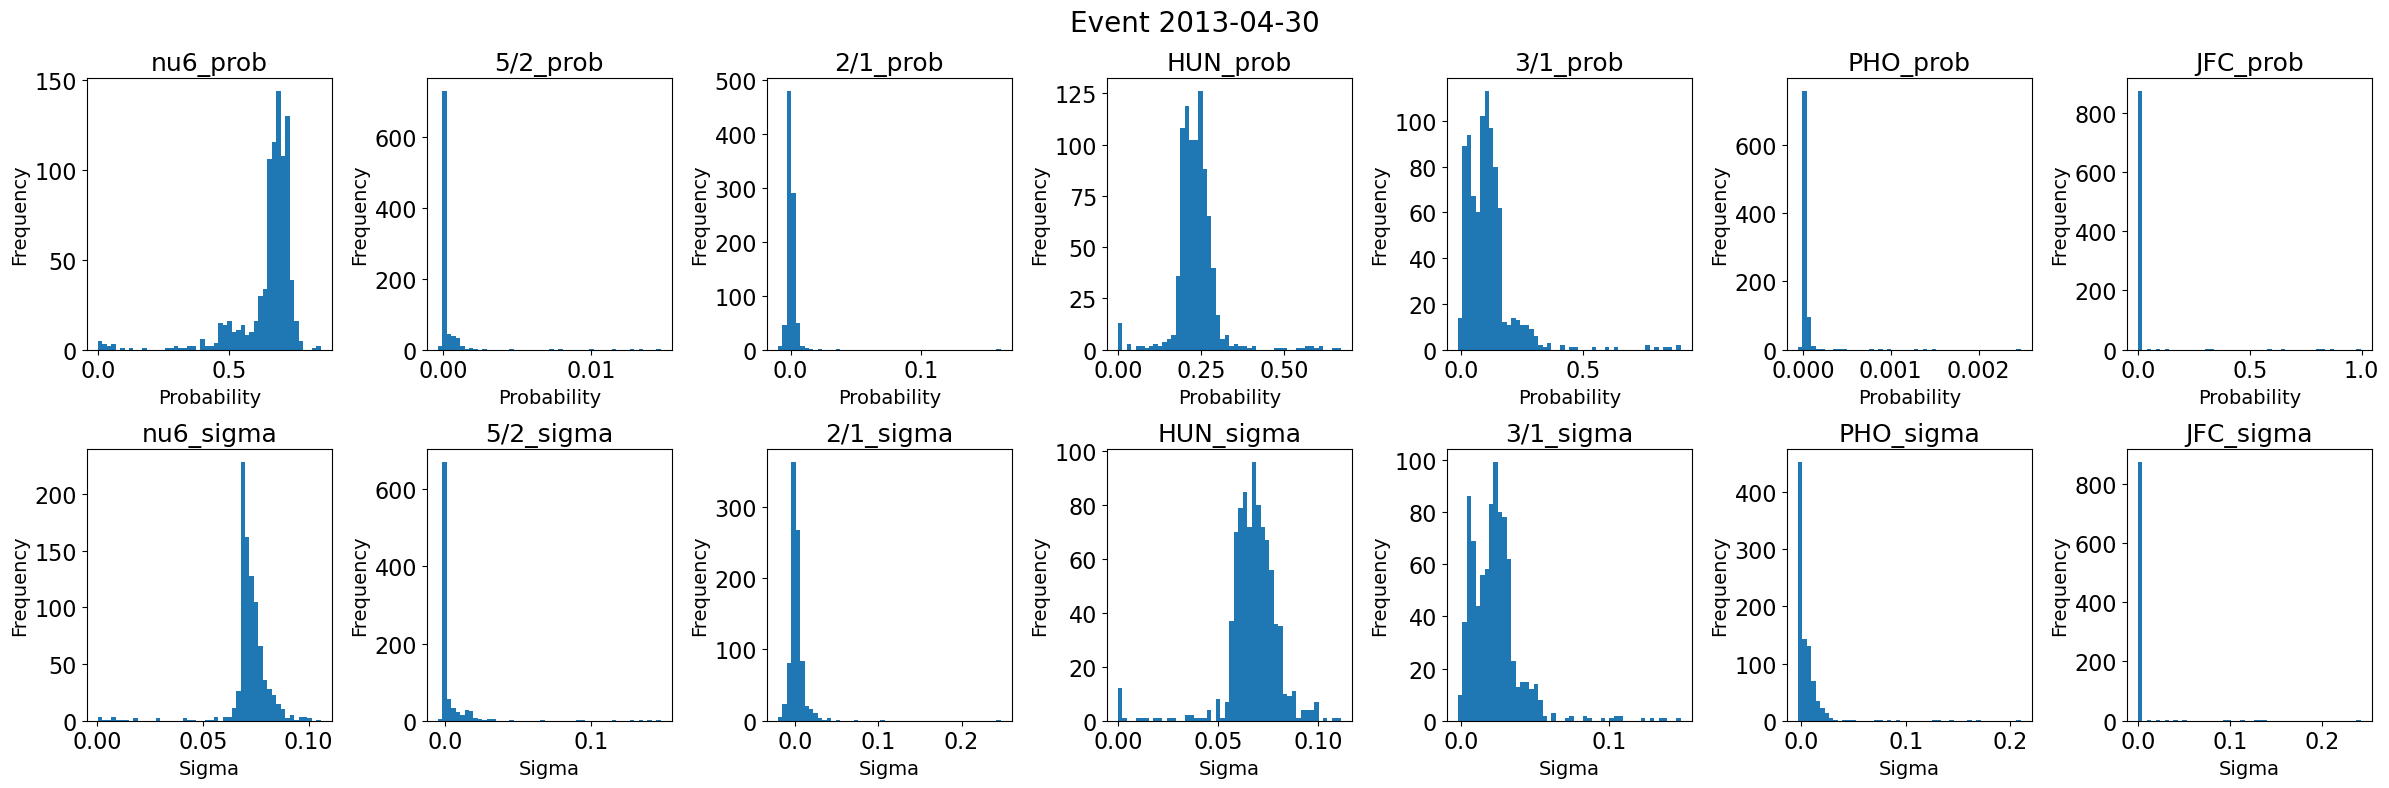

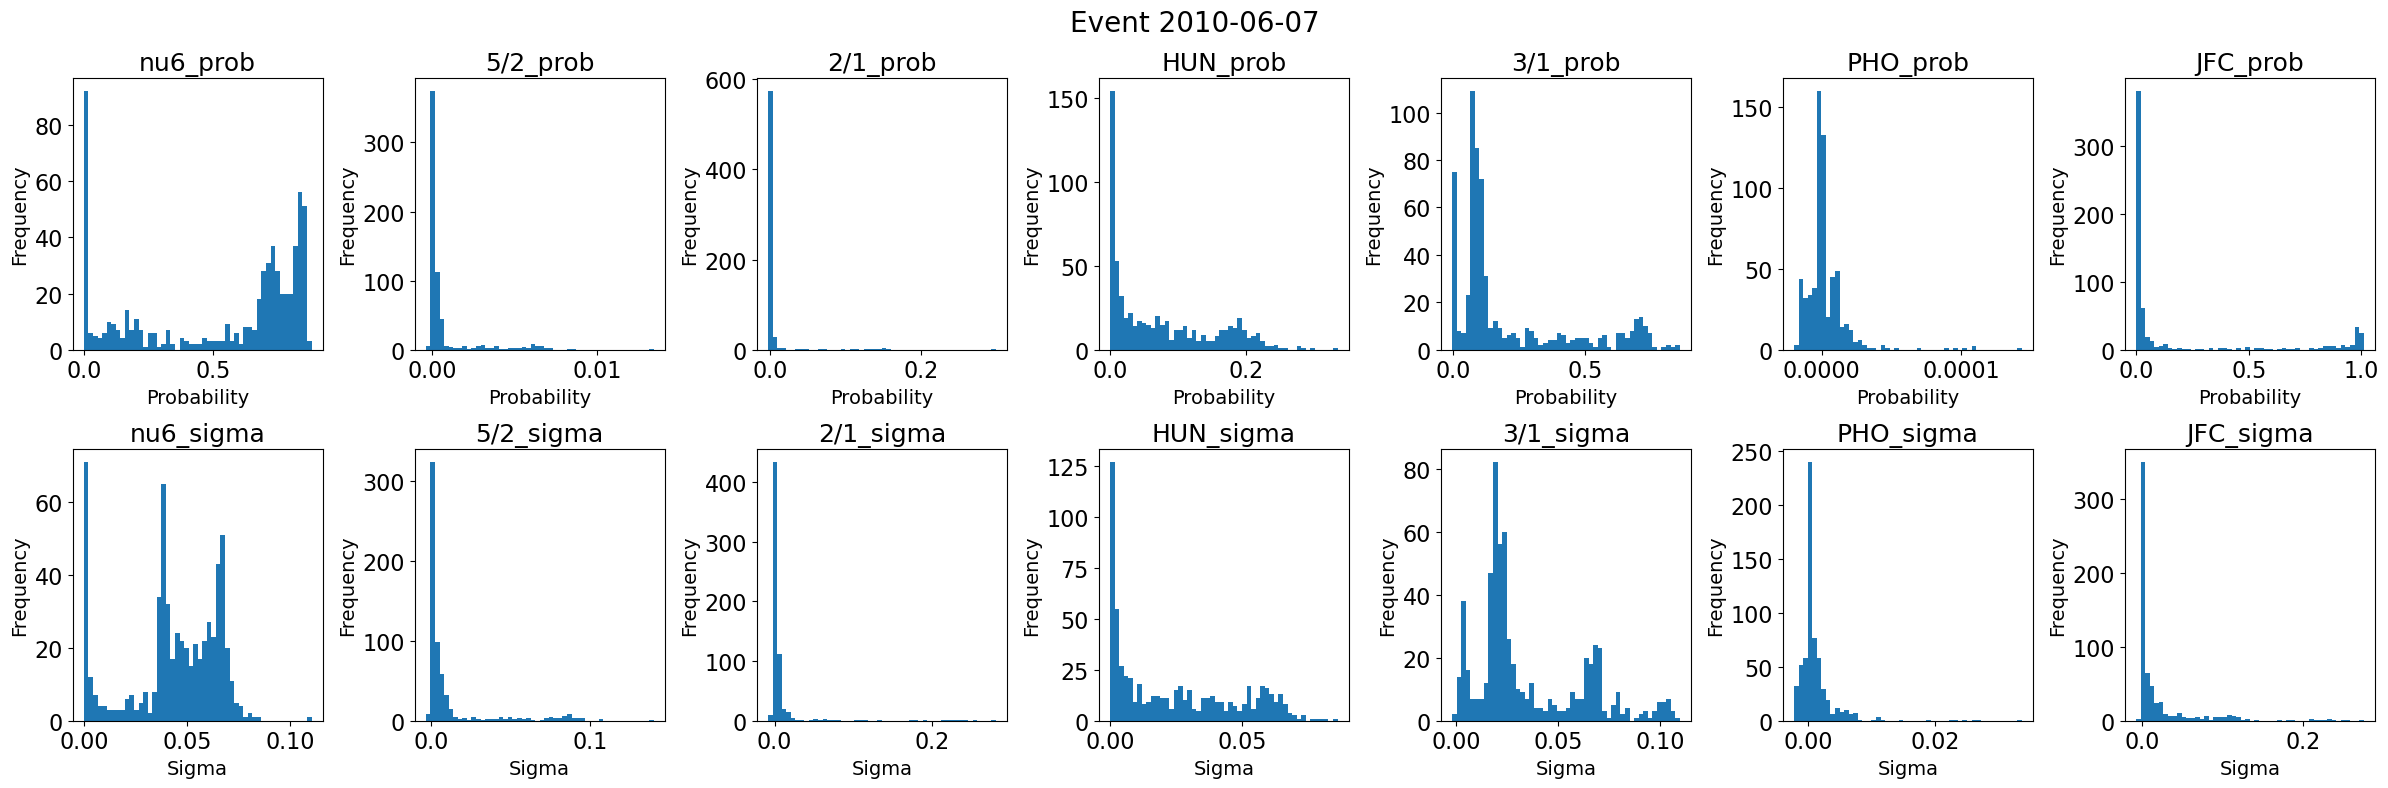

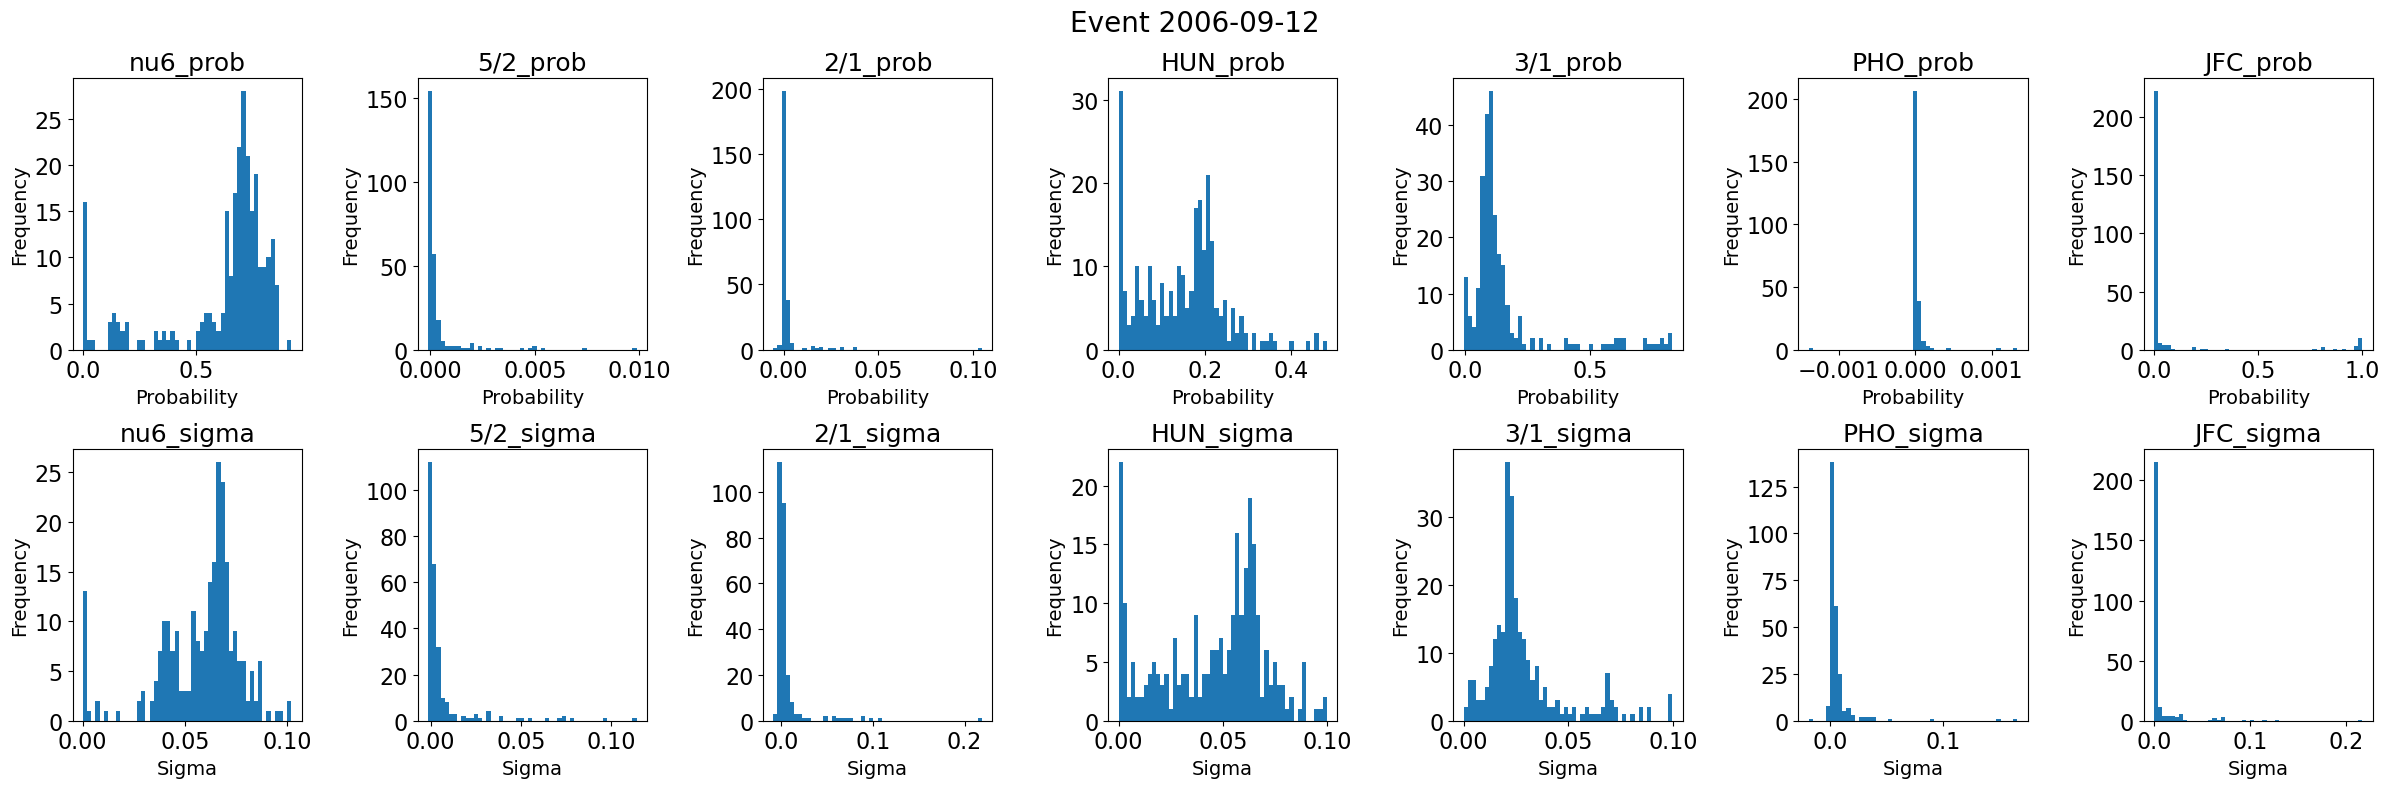

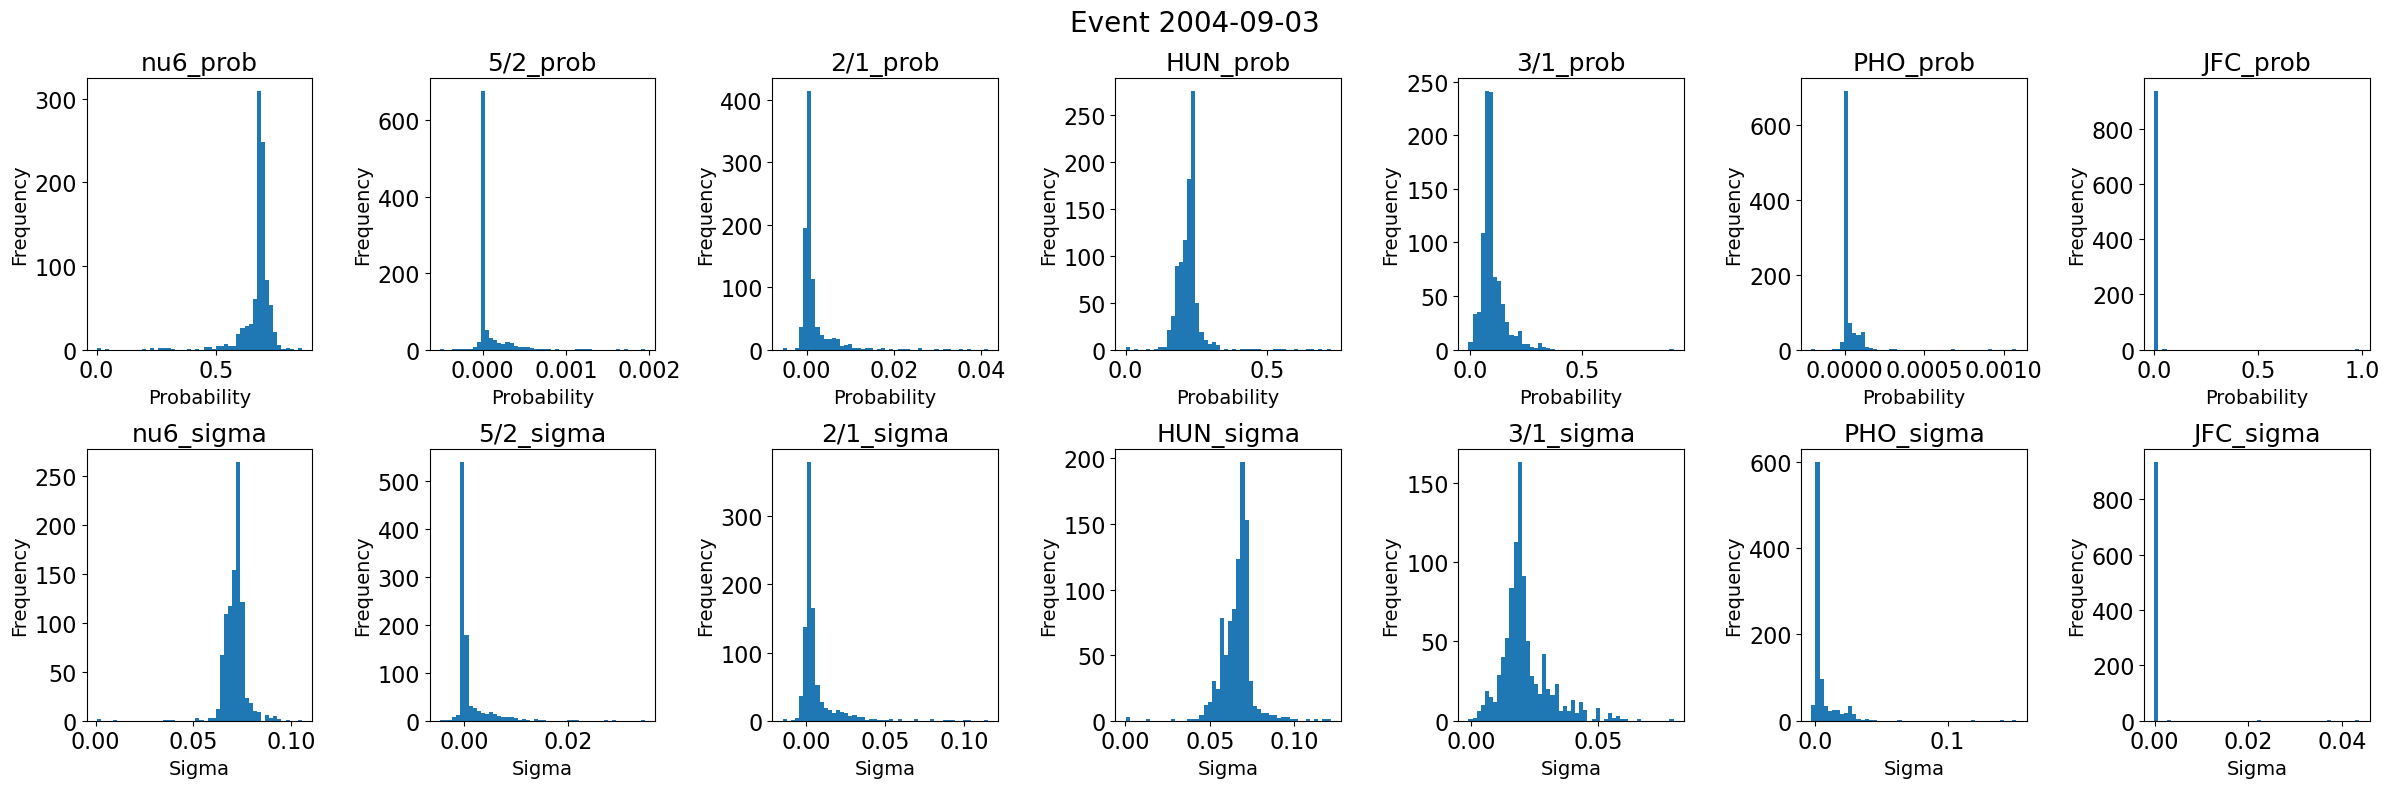

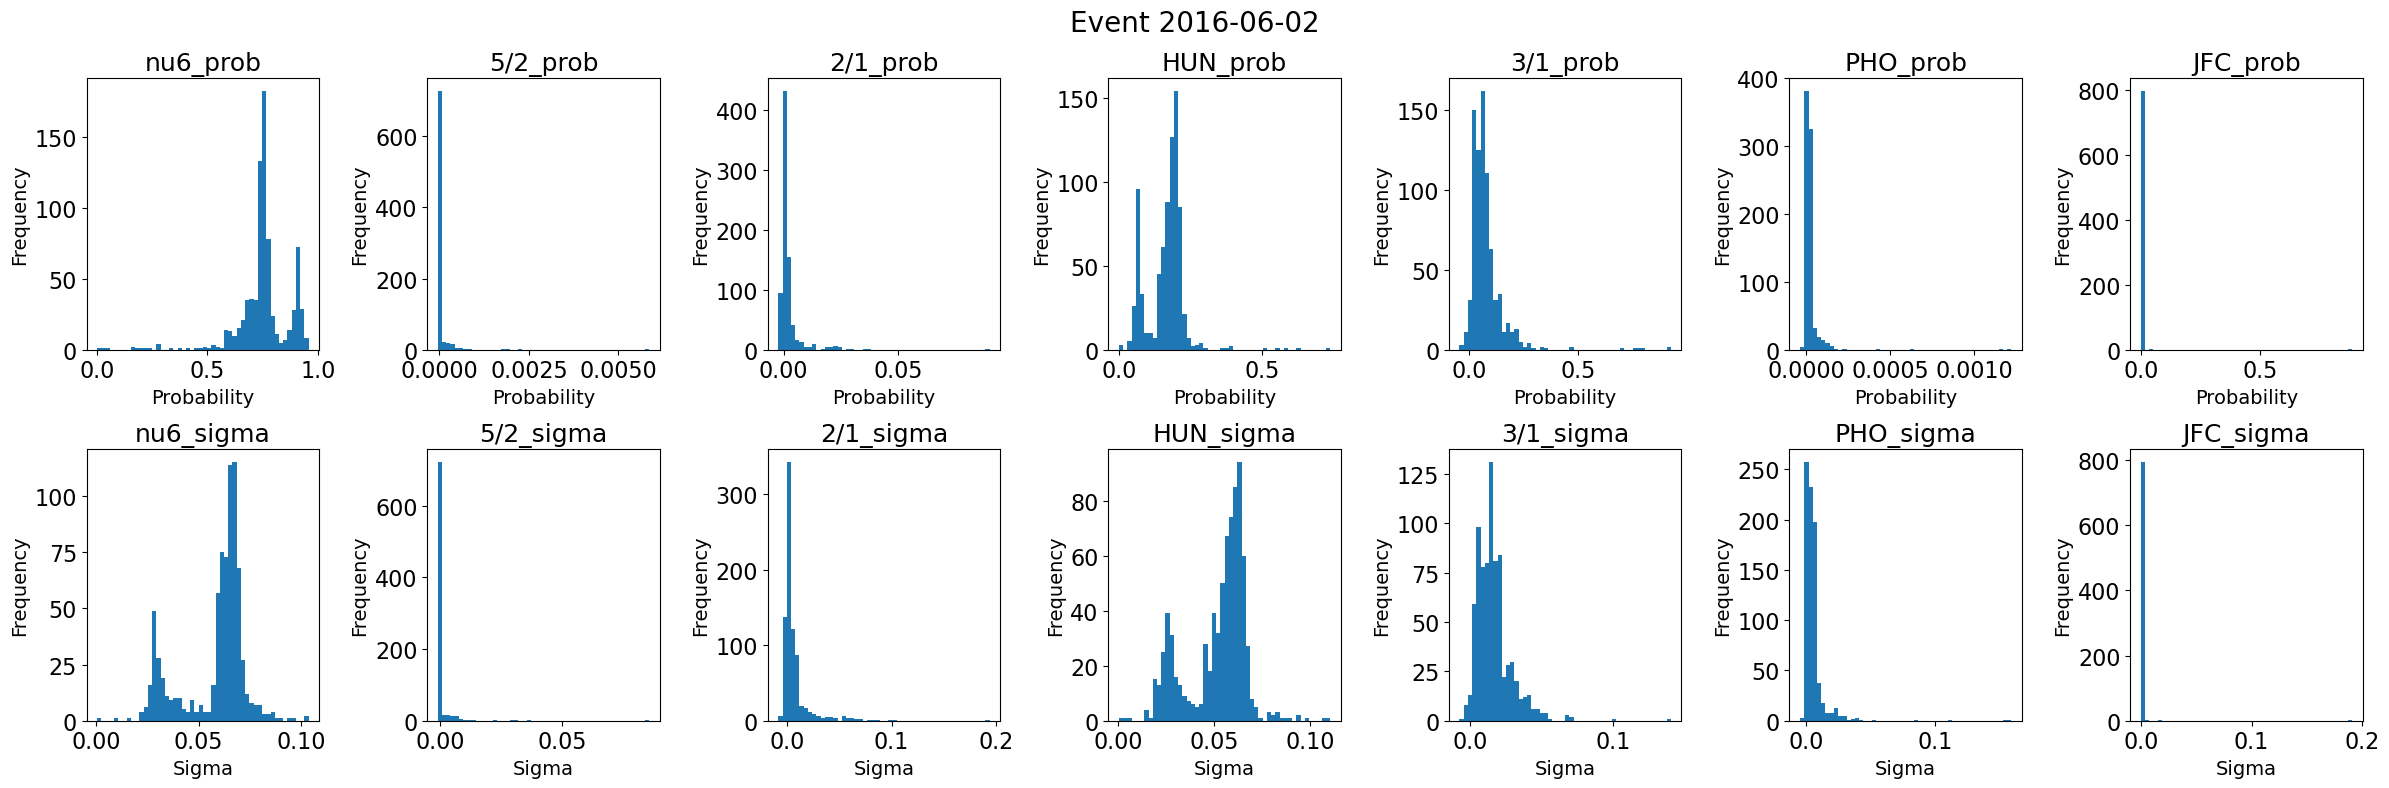

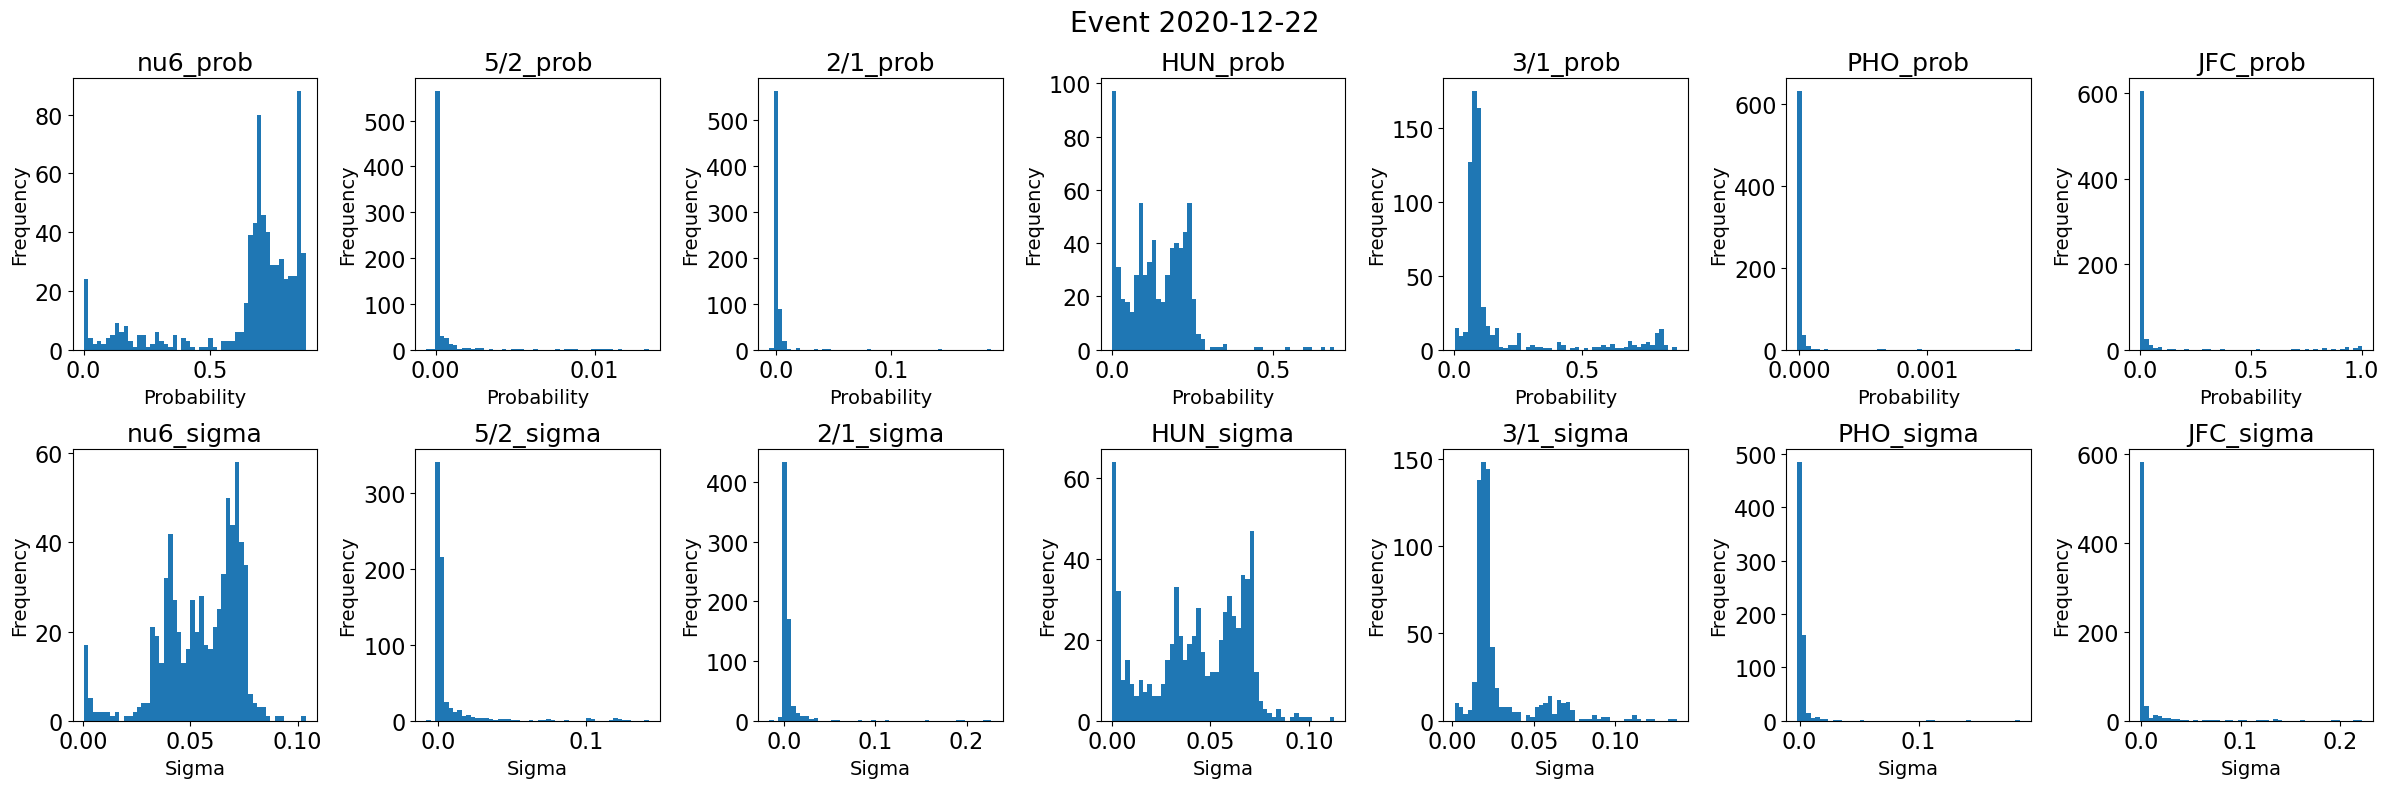

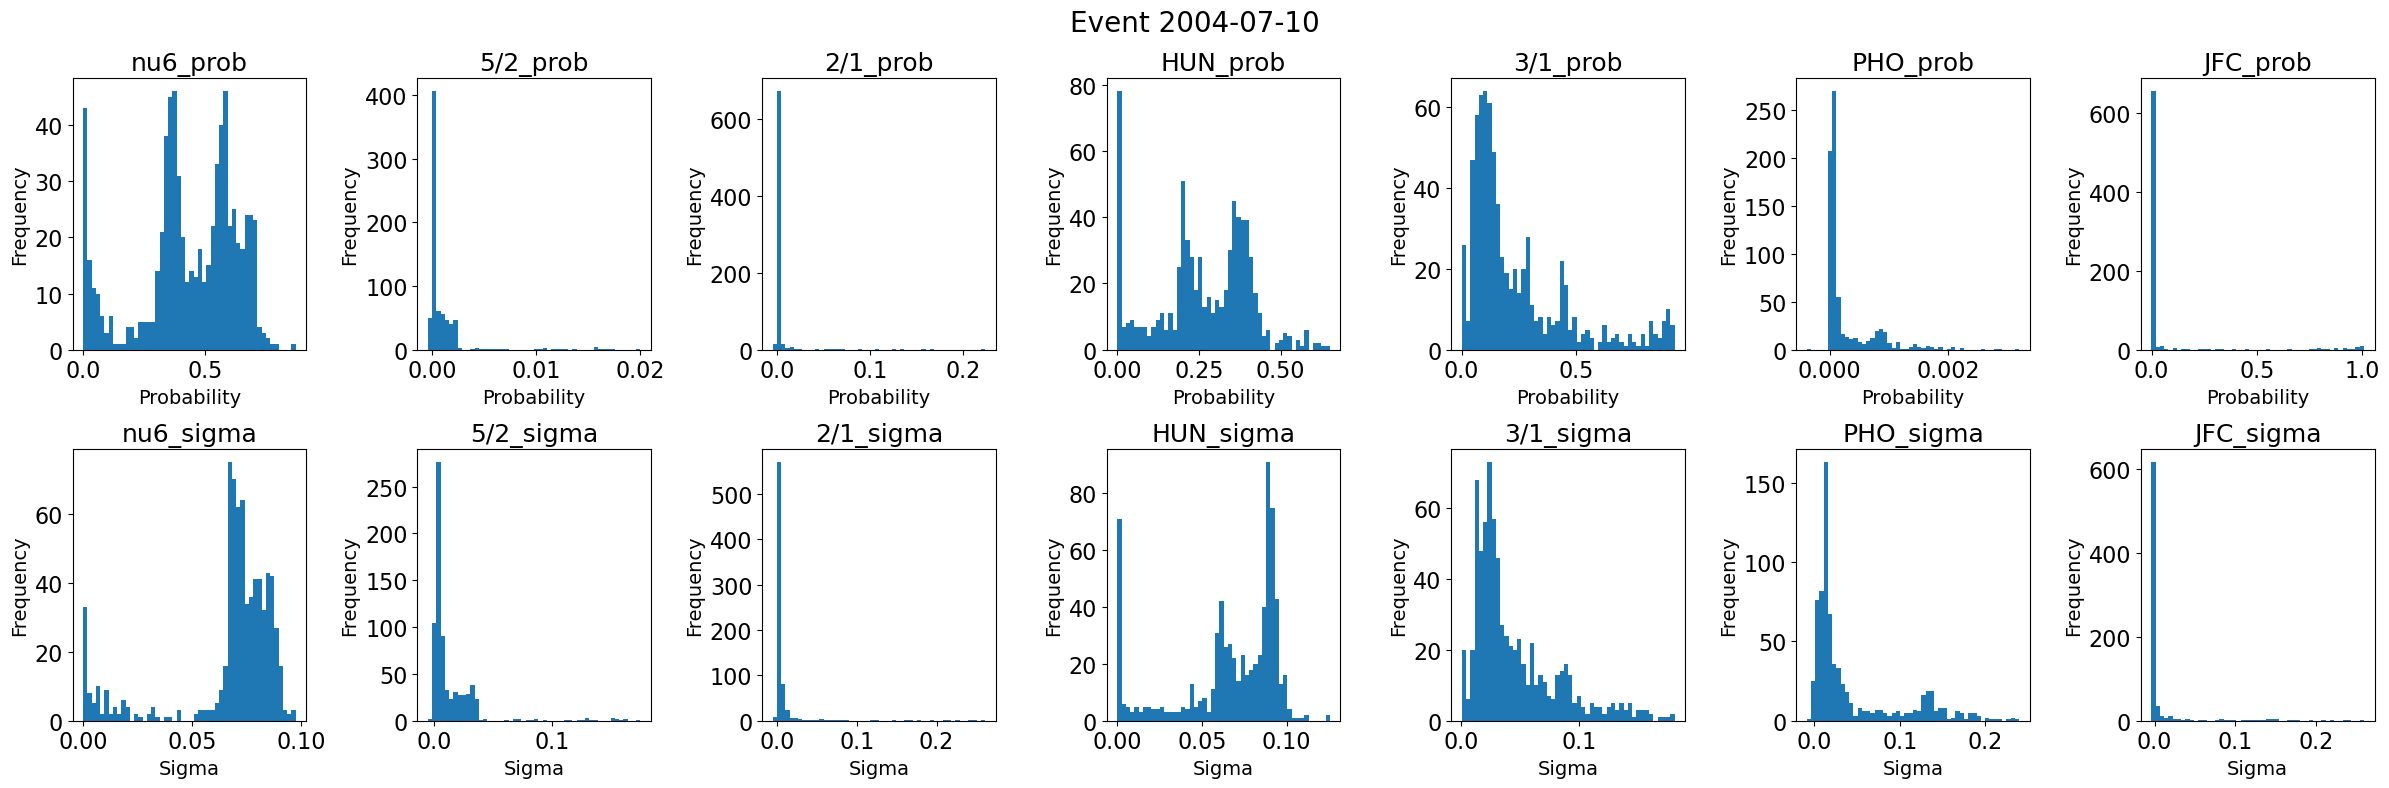

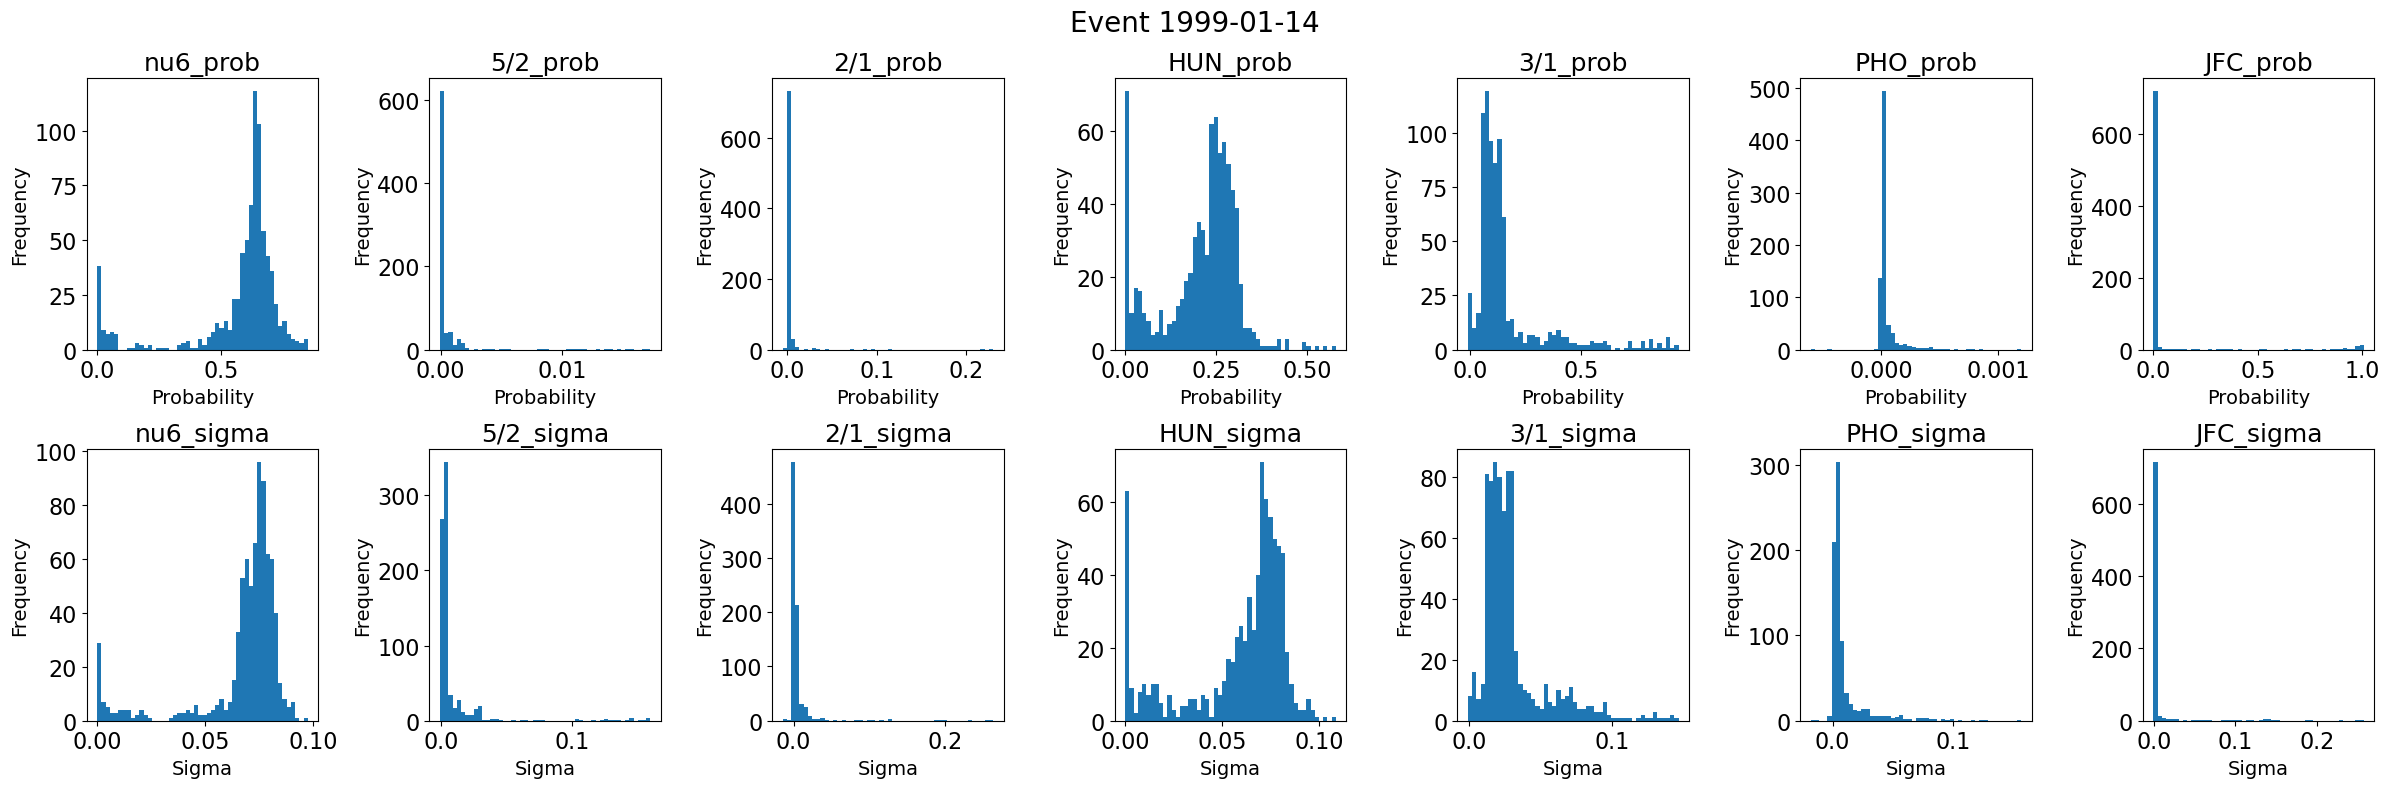

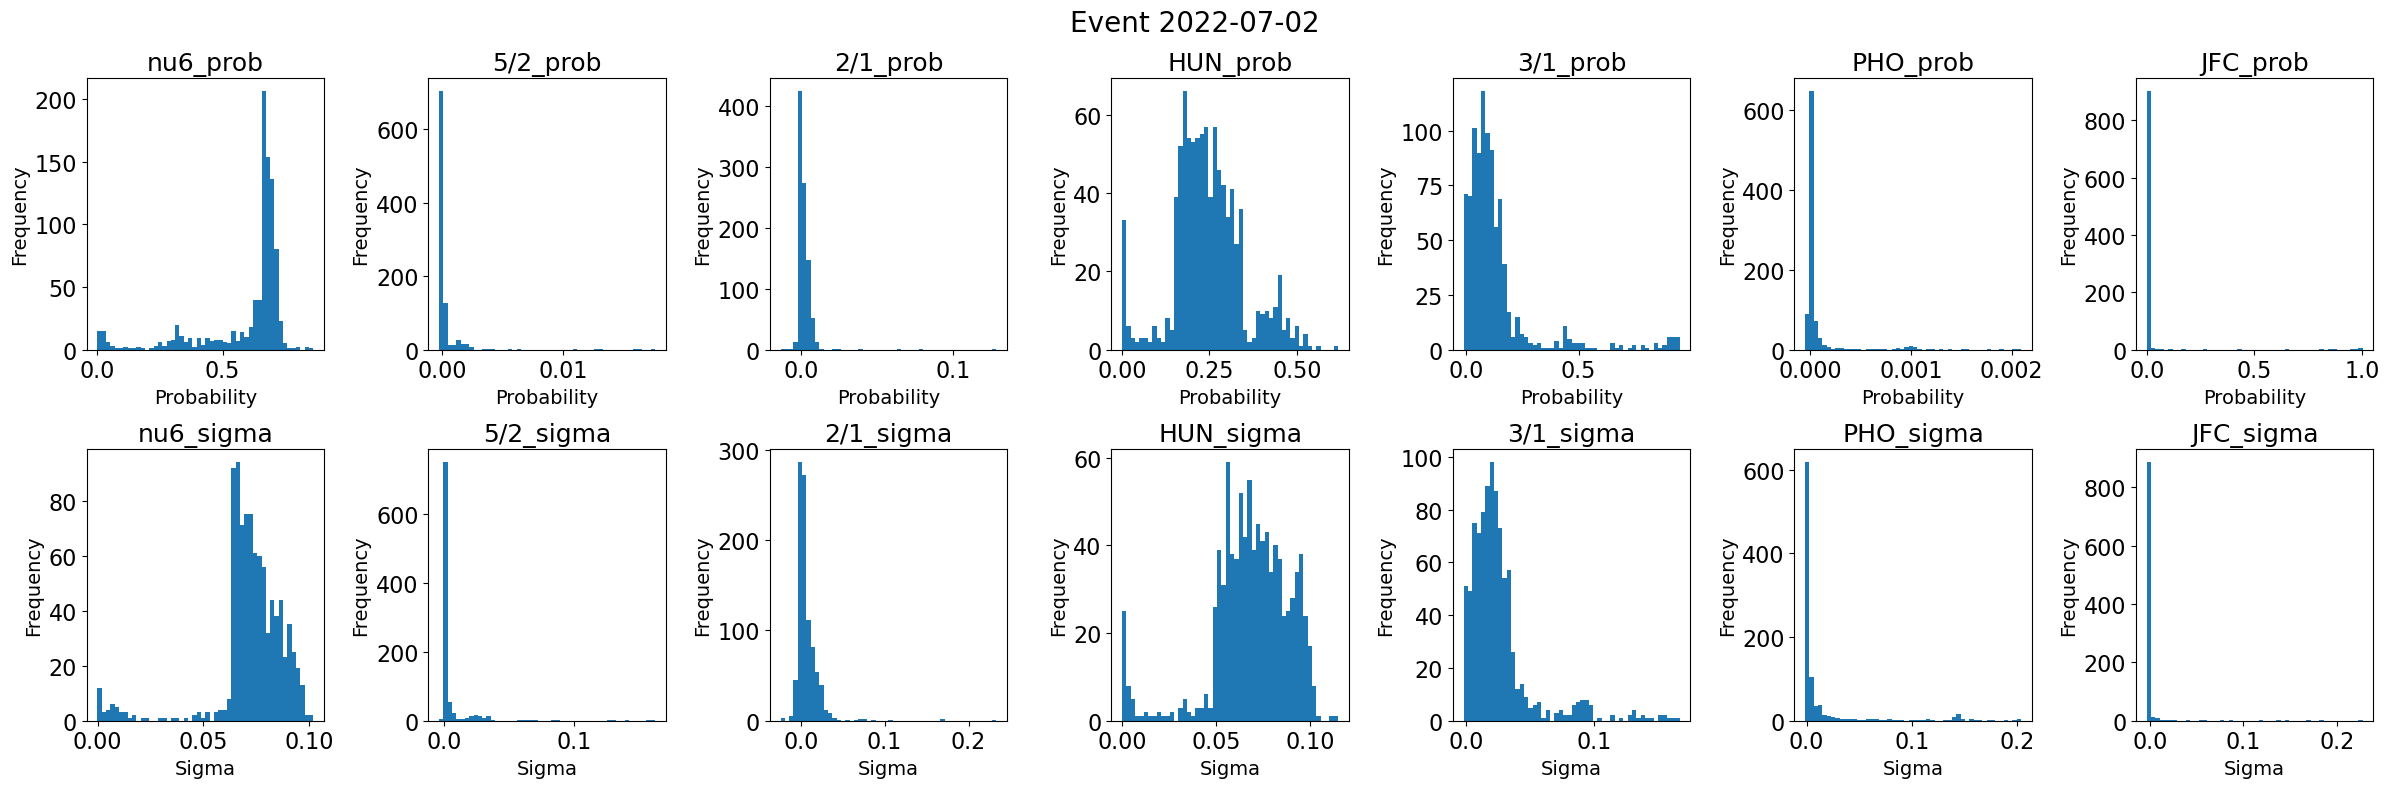

In [29]:
nrows = 2  # number of rows in each plot
ncols = 7  # number of columns in plot
n_bins = 50  # number of bins in the histogram

# iterate over every event, plotting histograms for all the escape region probabilities and sigmas
for event_ind_interp in tqdm(range(0, len(impactor_state_vectors))):
    # create the plot
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (24, 8), dpi=100)  # make figure with subplots
    # plot the distirbution of all the probabilities/sigmas in a loop
    for i, param in enumerate(er_prob_sigma_params):
        prob_sigma = interp_probs_rectgrid_mc[i, event_ind_interp] # these are the probabilities/sigmas for all the mc samples for that event
        # i//ncols, i%ncols indexes the subplot axes: // is integer division (floor), % is modulus
        # plot histogram
        ax[i//ncols, i%ncols].hist(prob_sigma, bins=n_bins, label = prob_sigma)
        # set ylabel
        ax[i//ncols, i%ncols].set_ylabel('Frequency', fontsize=14)
        # set title
        ax[i//ncols, i%ncols].set_title(param, fontsize=18)
        # set axis tick fontsize
        ax[i//ncols, i%ncols].tick_params(axis='both', which='major', labelsize=16)
        ax[i//ncols, i%ncols].tick_params(axis='both', which='minor', labelsize=12)
        # set xlabel as either probability or sigma depending on parameter
        if 'prob' in param:
            ax[i//ncols, i%ncols].set_xlabel('Probability', fontsize=14)
        elif 'sigma' in param:
            ax[i//ncols, i%ncols].set_xlabel('Sigma', fontsize=14)
    # get the date of the event
    event_date = pd.to_datetime(impactor_state_vectors['Time'], 
                                format='%Y%m%d-%H%M%S.%f').dt.strftime('%Y-%m-%d').iloc[event_ind_interp]
    # title
    fig.suptitle('Event ' + event_date, fontsize=20)
    # tight layout
    plt.tight_layout()
    # save
    plt.savefig(f'escape_region_probs_sigmas_plots/er_probs_sigmas_event_{event_date}.png')

Get the $a$, $e$, $i$ from Borovicka et al. (2013) and run it through the Granvik model, then compare to the Chelyabinsk ER probability/sigma plots to see if it agrees with what we get from our pipeline; should be a validation step.

$H$ is given as $26.17$ in pp. $5$ of the correspondoing supplementary information paper but that is above the maximum $H$ sampled by the Granvik model; since the interpolator gives `nan` in that case we use the maximum $H$ in the Granvik file instead, as the Monte Carlo samples do as well

In [30]:
# aei values are taken from Table 2 of Borovicka et al. (2013)
# H absolute magnitude is the same used for the Monte Carlo samples (maximum H value in the Granvik file)
borovicka_aeih = np.array([1.72, 0.571, 4.98, H])     

Run it through the interpolated Granvik model and then compare to the Chelyabinsk ER probability/sigma plots:

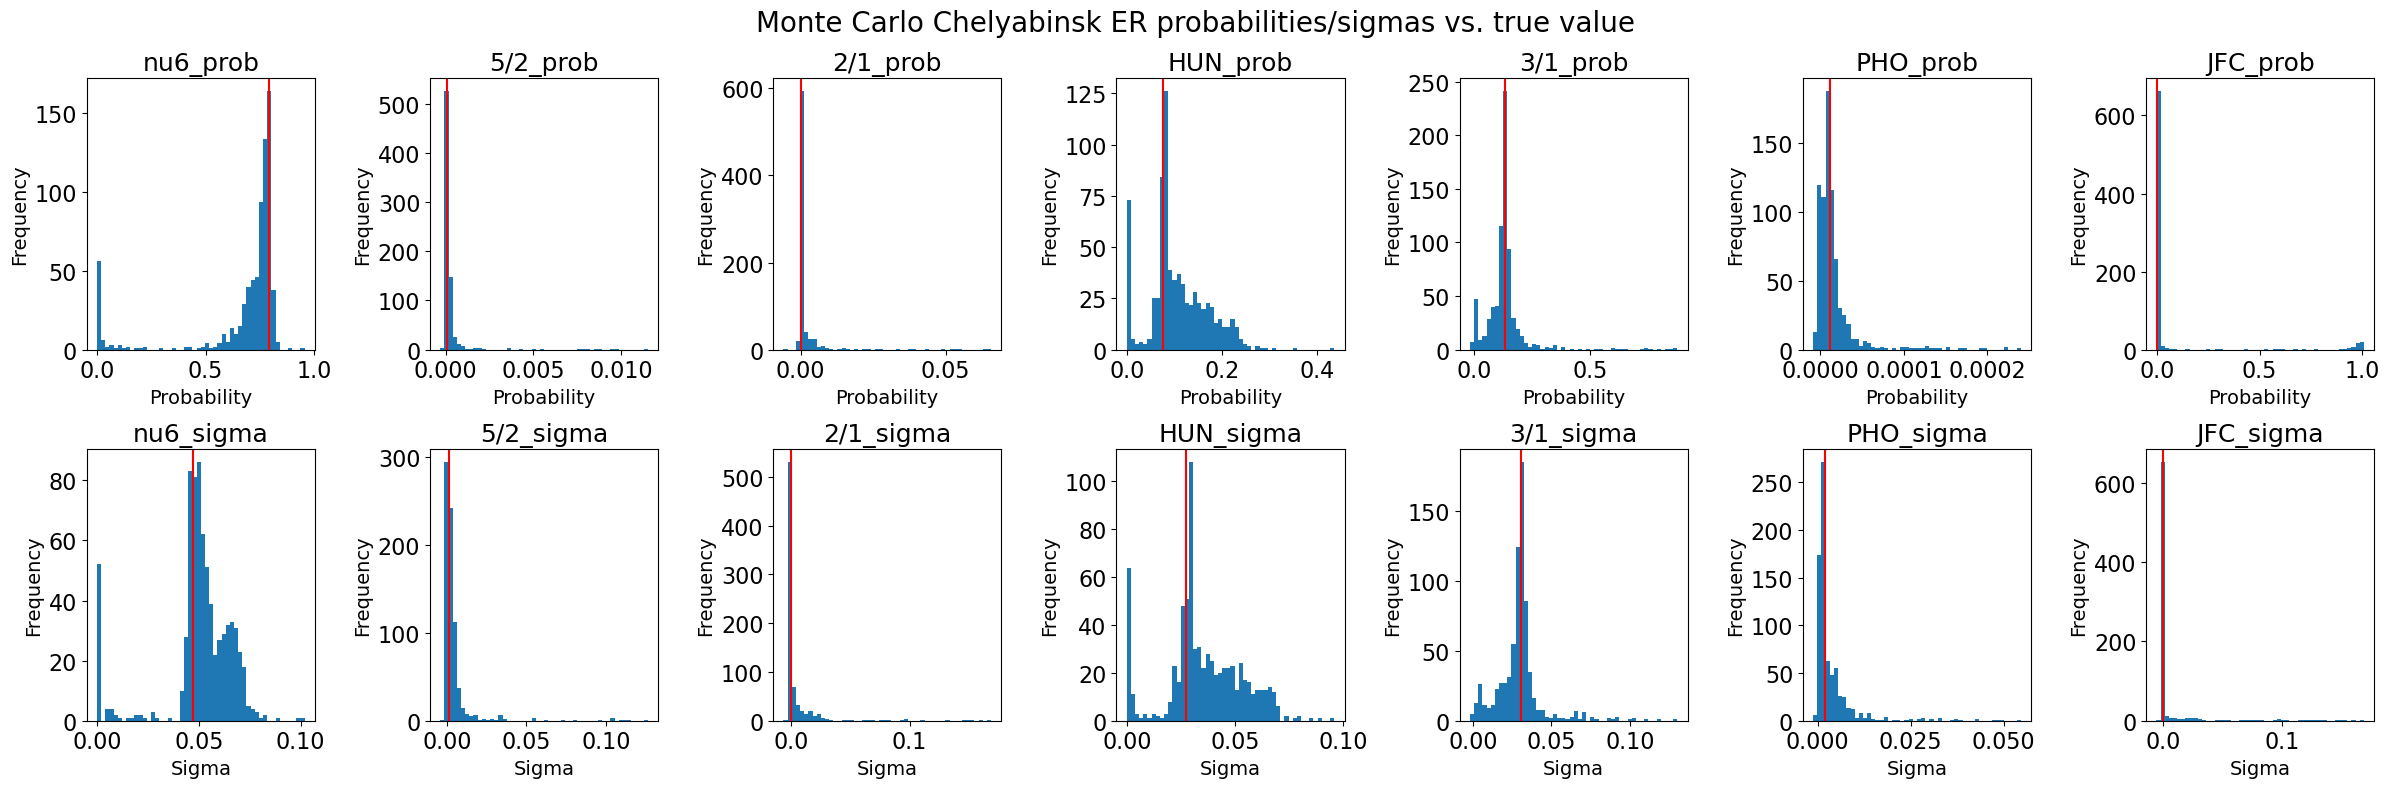

In [31]:
chel_index = 0  # chelyabinsk index

# make figure with subplots
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (24, 8), dpi=100)  

# plot the distirbution of all the probabilities/sigmas in a loop
for i, param in enumerate(er_probs_sigmas.columns):
    # get the er probability/sigma
    column_prob = np.array(grid_probs[param]).reshape(len(granvik_smas), len(granvik_eccs), len(granvik_incs), len(granvik_Hs))
    # build the rectilinear grid interpolator for that parameter
    rectgrid_interpolator = scipy.interpolate.RegularGridInterpolator((granvik_smas, granvik_eccs, granvik_incs, granvik_Hs), column_prob, 
                                                                      method=rectgrid_method, bounds_error=False, fill_value=np.nan)
    # these are the probabilities/sigmas for all the chelyabinsk mc samples
    mc_prob_sigma = rectgrid_interpolator(mc_aeihs[chel_index])
    # this is the probability/sigma for the "true" value derived from the Borovicka et al. (2013) aeih values
    borovicka_prob_sigma = rectgrid_interpolator(borovicka_aeih)
    
    # plotting:
    # i//ncols, i%ncols indexes the subplot axes: // is integer division (floor), % is modulus
    # plot histogram of the distribution of mc samples
    ax[i//ncols, i%ncols].hist(mc_prob_sigma, bins=n_bins, label = param)
    # plot the "true" value derived from the Borovicka et al. 2013 aeih values
    # print(borovicka_prob_sigma)
    ax[i//ncols, i%ncols].axvline(x=borovicka_prob_sigma, color='r')
    # set ylabel
    ax[i//ncols, i%ncols].set_ylabel('Frequency', fontsize=14)
    # set title
    ax[i//ncols, i%ncols].set_title(param, fontsize=18)
    # set axis tick fontsize
    ax[i//ncols, i%ncols].tick_params(axis='both', which='major', labelsize=16)
    ax[i//ncols, i%ncols].tick_params(axis='both', which='minor', labelsize=12)
    # set xlabel as either probability or sigma depending on parameter
    if 'prob' in param:
        ax[i//ncols, i%ncols].set_xlabel('Probability', fontsize=14)
    elif 'sigma' in param:
        ax[i//ncols, i%ncols].set_xlabel('Sigma', fontsize=14)
        
# title
fig.suptitle('Monte Carlo Chelyabinsk ER probabilities/sigmas vs. true value', fontsize=20)
# tight layout
plt.tight_layout()
# save figure
plt.savefig('escape_region_probs_sigmas_plots/chelyabinsk_er_prob_sigma_true.png')

this looks really good!

Import `.csv` of telescopically observed NEOs from NASA small-body database with $26.5 \leq H \leq 28.5$ and condition code $\leq 5$ (around $\sim 300$ objects) and then run all their $a$, $e$, $i$ values (again setting $H$ equal to max $H$ in the Granvik model) through the interpolated Granvik model

In [32]:
# import the telescopically observed neos from NASA's small-body database
sbdb_dm_neos = pd.read_csv('telescopic_decameter_neos.csv', sep=',')
# get the a, e, i, values and use the same H as for everything else:
sbdb_aeis = np.array(sbdb_dm_neos[['a', 'e', 'i']])
# add Hs to the aei values
sbdb_aeihs = np.concatenate((sbdb_aeis, np.ones(((sbdb_aeis.shape[0]), 1)) * H), axis=1)

And perform the rectilinear grid interpolation for all the $a$, $e$, $i$, $H$ values of the telescopically observed NEOs:

In [33]:
# interpolated probabilities drawn from the granvik model, with the shape (number of escape regions, number of small bodies)
interp_probs_rectgrid_sbdb = np.zeros((len(er_probs_sigmas.columns), len(sbdb_aeihs)))

# perform the interpolation
for i, column in tqdm(enumerate(er_probs_sigmas.columns)):
    # get the probability/sigma for the given escape region
    column_prob = np.array(grid_probs[column]).reshape(len(granvik_smas), len(granvik_eccs), len(granvik_incs), len(granvik_Hs))
    # build the interpolator for the given escape region probability/sigma using cubic splines
    # fill any values outside the grid with nans
    rectgrid_interpolator_sbdb = scipy.interpolate.RegularGridInterpolator((granvik_smas, granvik_eccs, granvik_incs, granvik_Hs), column_prob, 
                                                                      method=rectgrid_method, bounds_error=False, fill_value=np.nan)
    # interpolate all the sbdb aeih samples
    interp_probs_rectgrid_sbdb[i] = rectgrid_interpolator_sbdb(sbdb_aeihs)

14it [00:10,  1.33it/s]


Plot the ER prob/sigma distribution of these events to see how they compare to the MC sample distribution of our decameter impactors:

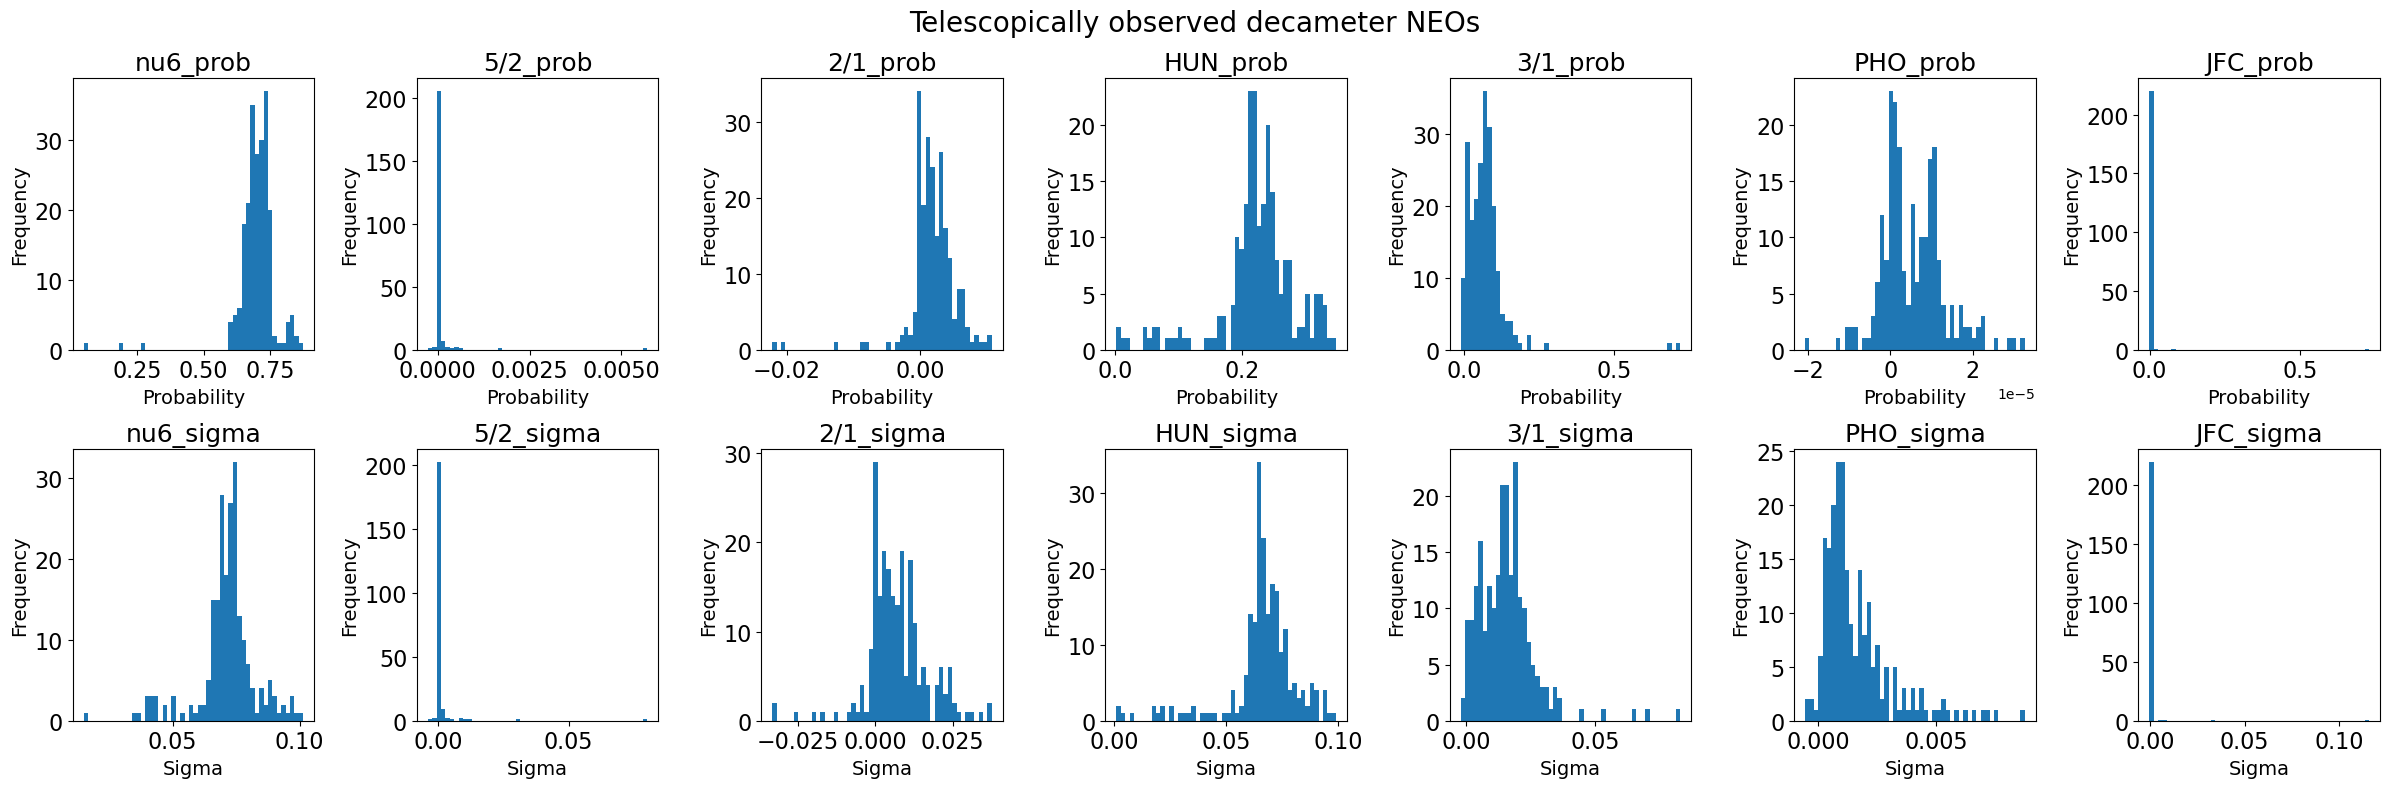

In [34]:
# make figure with subplots
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize = (24, 8), dpi=100)  

# plot the distirbution of all the sbdb probabilities/sigmas in a loop
for i, param in enumerate(er_probs_sigmas.columns):
    # plot the sbdb probabilities/sigmas
    ax[i//ncols, i%ncols].hist(interp_probs_rectgrid_sbdb[i], bins=n_bins)
    # set ylabel
    ax[i//ncols, i%ncols].set_ylabel('Frequency', fontsize=14)
    # set title
    ax[i//ncols, i%ncols].set_title(param, fontsize=18)
    # set axis tick fontsize
    ax[i//ncols, i%ncols].tick_params(axis='both', which='major', labelsize=16)
    ax[i//ncols, i%ncols].tick_params(axis='both', which='minor', labelsize=12)
    # set xlabel as either probability or sigma depending on parameter
    if 'prob' in param:
        ax[i//ncols, i%ncols].set_xlabel('Probability', fontsize=14)
    elif 'sigma' in param:
        ax[i//ncols, i%ncols].set_xlabel('Sigma', fontsize=14) 
# title
fig.suptitle('Telescopically observed decameter NEOs', fontsize=20)
# tight layout
plt.tight_layout()
# save figure
plt.savefig('escape_region_probs_sigmas_plots/telescopic_decameter_neo_distributions.png')

Again seem to come mostly from the inner main belt belt; $\nu_6$ the most likely with some probability of Hungaria or $3/1$

Making $a$, $e$, $i$ heatmaps of the telescopically observed decameter objects and compare them to the observed impactors:

First compute the "true" $a$, $e$, $i$ values of the observed impactors with `WMPL`:

In [ ]:
# each event has a true aei
# shape (number of events, number of orbital parameters to get)
true_aeis = np.zeros((len(impactor_state_vectors), len(orb_param_variables)))

# get aeis in loop
for i, event in tqdm(impactor_state_vectors.iterrows()):
    # get state vectors
    v, t, a, o, e, zen, azim = event  # since it should be in that order in impactor_state_vectors table
    # zenith is 90 - alt
    alt = 90 - zen
    # run wmpl
    output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v}', '-t', f'{t}', '-a', f'{a}', 
                             '-o', f'{o}', '-e', f'{e}', '--azim', f'{azim}', '--alt', f'{alt}', 
                             '--vrotcorr', '--statfixed'], capture_output=True)
    # get orbital parameters from the output in the order of orb_param_variables
    true_aeis[i] = np.array([np.float64(string) for param in [elem for elem in 
                                                              list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                              if elem.startswith(tuple(orb_param_variables))] 
                             for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])

9it [00:22,  2.46s/it]

And get the $a$, $e$, $i$s for the impactors and for the telescopically observed objects:

In [ ]:
# impactors
true_as, true_es, true_is = true_aeis.T[a_index], true_aeis.T[e_index], true_aeis.T[i_index]
# telescopically observed
sbdb_as, sbdb_es, sbdb_is = sbdb_aeis.T

Plot $a$ vs. $e$ and $a$ vs. $i$ for all the Monte Carlo samples:

In [ ]:
# Plotting:
fig = plt.figure(figsize = (12, 16))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# get the event and plot in a loop
for index, event in enumerate(mc_aeis):
    # event a e and is
    event_as, event_es, event_is = event.T
    # get the date of the event
    event_date = pd.to_datetime(impactor_state_vectors['Time'], 
                                format='%Y%m%d-%H%M%S.%f').dt.strftime('%Y-%m-%d').iloc[index]
    # plot event
    ax1.scatter(event_as, event_es, s=0.1, label = event_date)  # a vs. e
    ax2.scatter(event_as, event_is, s=0.1, label = event_date)  # a vs. i
    # set the limits to physically reasonable quantities
    ax1.set_xlim(0.5, 4.5), ax1.set_ylim(0, 1.)  # a from 0.5 to 4.5 au, e from 0 to 1
    ax2.set_xlim(0.5, 4.5), ax2.set_ylim(0., 60.)  # a from 0.5 to 4.5 au, i from 0 to 60 degrees
    # legend
    ax1.legend(loc='lower right', markerscale=20.)
    # ax2.legend(loc='upper right', markerscale=20.)
# set x and y labels
ax.set_xlabel('a (AU)'), ax1.set_ylabel('e'), ax2.set_ylabel('i (deg)')
# tight layout
plt.tight_layout()
plt.show()

Plot $a$ vs. $e$ and $a$ vs. $i$ for the telescopically observed decameter asteroids and compare those to the impactors:

In [ ]:
fig = plt.figure(figsize = (12, 16))
# make subplots
ax = fig.add_subplot(111)    # The big subplot
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
# telescopically observed
ax1.scatter(sbdb_as, sbdb_es, s=1., c='C0', label = 'Telescopically observed')  # a vs. e
ax2.scatter(sbdb_as, sbdb_is, s=1., c='C0', label = 'Telescopically observed')  # a vs. i
# impactors
ax1.scatter(true_as, true_es, s=10, c='orange', label = 'Impactors')  # a vs. e
ax2.scatter(true_as, true_is, s=10, c='orange', label = 'Impactors')  # a vs. i
# label
ax.set_xlabel('a (AU)')
ax1.set_ylabel('e')
ax2.set_ylabel('i (deg)')
# legend
lgnd = ax1.legend(loc='lower right')
lgnd.legend_handles[0]._sizes = [25]
lgnd.legend_handles[1]._sizes = [25]
# tight layout
plt.tight_layout()

The big outlier with high SMA is the 2018 Bering Sea event

Very low SMA is the 2016 event

#### Testing/Debugging:

Try drawing a KDE:

In [ ]:
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)
    

In [ ]:
m1 = np.random.normal(size=1000)
m2 = np.random.normal(scale=0.5, size=1000)

x, y = m1 + m2, m1 - m2

xx, yy = np.mgrid[x.min():x.max():100j, 
                  y.min():y.max():100j]

xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
xy_train  = np.vstack([y, x]).T

xy_train

In [ ]:
kde_model_dv = KernelDensity(bandwidth=dv_bandwidth, kernel=kernel_type)

In [ ]:
kde_granvik = KernelDensity(bandwidth=1., kernel='gaussian').fit(np.array(granvik_aeihs))

In [ ]:
kde_granvik

In [ ]:
granvik_aeihs

In [ ]:
for i, event in enumerate(aeihs):
    pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
    
rb_param_array_single_event = np.asarray(list(tqdm(pool.imap(get_orbital_parameters, state_vector_par_list))))

Stepsize in:

- SMA: 0.1
- Ecc: 0.04
- Inc: 4
- H: 0.25
  

In [ ]:
def lerp_4d():
    """
    Basic 4d lerp function only taking into account the adjacent two points
    """
    

In [ ]:
# index of smallest element of smas greater than 2, this is the index of the interpolation upper bound
interp_ub_sma_ind = np.where(smas == smas[smas >= 2.002317].min())
# index of largest element of smas less than 2, this is the index of the interpolation lower bound
interp_lb_sma_ind = np.where(smas == smas[smas <= 2.002317].max())

In [ ]:
# index of smallest element of smas greater than 2, this is the index of the interpolation upper bound
interp_ub_ecc_ind = np.where(eccs == eccs[eccs >= 0.636153].min())
# index of largest element of smas less than 2, this is the index of the interpolation lower bound
interp_lb_ecc_ind = np.where(eccs == eccs[eccs <= 0.636153].max())

In [ ]:
# index of smallest element of smas greater than 2, this is the index of the interpolation upper bound
interp_ub_inc_ind = np.where(incs == incs[incs >= 5.553677].min())
# index of largest element of smas less than 2, this is the index of the interpolation lower bound
interp_lb_inc_ind = np.where(incs == incs[incs <= 5.553677].max())

In [ ]:
# index of smallest element of smas greater than 2, this is the index of the interpolation upper bound
interp_ub_H_ind = np.where(Hs == Hs[Hs >= 20.].min())
# index of largest element of smas less than 2, this is the index of the interpolation lower bound
interp_lb_H_ind = np.where(Hs == Hs[Hs <= 20.].max())

In [ ]:
from functools import reduce

common_index_ub = reduce(np.intersect1d, (interp_ub_sma_ind, interp_ub_ecc_ind, interp_ub_inc_ind, interp_ub_H_ind))
common_index_lb = reduce(np.intersect1d, (interp_lb_sma_ind, interp_lb_ecc_ind, interp_lb_inc_ind, interp_lb_H_ind))

In [ ]:
granvik_model.iloc[common_index_ub]

In [ ]:
granvik_model.iloc[common_index_lb]

In [ ]:
def add_epsilon(arr, eps=1e-12):
    """
    Helper function to add epsilons to an array with many repeating values to make them all unique, so that array can be used
    in interpolation
    """
    new_arr = []

    for elem in np.unique(arr):
        # print(elem)
        new_arr.append(list(np.add(arr[arr == elem], np.linspace(0., len(arr[arr == elem]) * eps, len(arr[arr == elem])))))

    return np.array([item for ls in new_arr for item in ls])

In [ ]:
new_smas = add_epsilon(smas)
new_eccs = add_epsilon(eccs)
new_incs = add_epsilon(incs)
new_Hs = add_epsilon(Hs)

In [ ]:
xtest_old = np.array(granvik_model[['sma', 'ecc', 'inc', 'Hmag']])
xtest_new = np.array((new_smas, new_eccs, new_incs, new_Hs)).T

In [ ]:
scipy.interpolate.RBFInterpolator(xtest_new, np.array(granvik_model['nu6_prob']), neighbors=1e4, kernel='linear')(np.array([[2.002317, 0.636153, 5.553677, 20.]]))

In [ ]:
scipy.interpolate.RegularGridInterpolator((new_smas, new_eccs, new_incs, new_Hs), np.array(granvik_model['nu6_prob']))

In [ ]:
len(np.unique(smas)), len(np.unique(eccs)), len(np.unique(incs)), len(np.unique(Hs))

In [ ]:
np.min(smas), np.max(smas)

In [ ]:
np.arange(np.min(smas), np.max(smas) + 0.1, 0.1)

In [ ]:
len(granvik_model['nu6_prob'])

In [ ]:
xtest_new.shape, np.array(granvik_model['nu6_prob']).shape

In [ ]:
np.array([
        [ 27.827,  18.53 , -30.417], [ 24.002,  17.759, -24.782],
        [ 22.145,  13.687, -33.282], [ 17.627,  18.224, -25.197],
        [ 29.018,  18.841, -38.761], [ 24.834,  20.538, -33.012],
        [ 26.232,  22.327, -27.735], [ 23.017,  23.037, -29.23 ],
        [ 28.761,  21.565, -31.586], [ 26.263,  23.686, -32.766]]).shape

In [ ]:
np.array([0.205,  0.197,  0.204,  0.197,  0.212,  
                   0.208,  0.204,  0.205, 0.211,  0.215]).shape

In [ ]:
def f(x, y, z):

    return 2 * x**3 + 3 * y**2 - z
x = np.linspace(1, 4, 11)
y = np.linspace(4, 7, 22)
z = np.linspace(7, 9, 33)
xg, yg ,zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)
data = f(xg, yg, zg)

In [ ]:
x.shape, y.shape, z.shape, data.shape

In [ ]:
np.array(granvik_model['nu6_prob']).shape

In [ ]:
new_smas.shape

In [ ]:
(np.array([[2.002317, 0.636153, 5.553677, 20.]]))

In [ ]:
eccs[eccs == 0.34].shape

In [ ]:
np.arange(0., len(eccs[eccs == 0.34])*eps, eps).shape

In [ ]:
len(eccs[eccs == 0.34])*eps

In [ ]:
np.add(eccs[eccs == 0.34], np.linspace(0., len(eccs[eccs == 0.34])*eps, len(eccs[eccs == 0.34])))

In [ ]:
new_eccs = []

for ecc in np.unique(eccs):
    new_eccs.append(list(np.add(eccs[eccs == ecc], np.arange(0., len(eccs[eccs == ecc])*eps, eps))))

new_eccs = np.array([item for ls in new_eccs for item in ls])

In [ ]:
smas, new_smas

In [ ]:
ytest = np.array(granvik_model[['nu6_prob', '5/2_prob', '2/1_prob', 'HUN_prob', '3/1_prob', 'PHO_prob', 'JFC_prob', 
                   'nu6_sigma', '5/2_sigma', '2/1_sigma', 'HUN_sigma']], dtype=np.float64)

In [ ]:
interp_ub_sma_ind, interp_lb_sma_ind

In [ ]:
interp_ub_ecc_ind, interp_lb_ecc_ind

In [ ]:
interp_ub_inc_ind, interp_lb_inc_ind

In [ ]:
orb_param_array_all_events[0, 1]

In [ ]:
granvik_model

Debugging for individual state vector-to-orbital element computations:

In [ ]:
state_vector_index = 0

dv, v, t, a, o, e, azim, zen = state_vector_par_list[state_vector_index]
alt = 90 - zen

output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v + dv}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
            '--azim', f'{azim}', '--alt', f'{alt}', '--vrotcorr', '--statfixed'], capture_output=True)
# [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) if elem.startswith(tuple(orb_param_variables))]

In [ ]:
test = np.array([np.float64(string) for param in [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                           if elem.startswith(tuple(orb_param_variables))] 
          for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])

In [ ]:
if not test.size:
    test = np.repeat('EMPTY', len(orb_param_variables))

In [ ]:
test

In [ ]:
state_vector_par_list[0]

In [ ]:
90 - 50.49624884

In [ ]:
12.08304597 -2.5400464418708926

In [ ]:
pooltest = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
orb_param_list = list(tqdm(pooltest.imap(get_orbital_parameters, state_vector_par_list)))

In [ ]:
np.array(orb_param_list)

Test if the multiprocessing is working

In [ ]:
# def get_orbital_parameters(state_vector_params, orb_param_variables=['a', 'e', 'i', 'peri', 'node', 'M']):
#     """
#     Gets the orbital parameter values corresponding to each parameter in orb_param_variables from the state vector state_vector

#     param state_vector_params: tuple of (dv, v, t, a, o, e, azim, alt):
#     dv is the velocity uncertainty to be added to the velocity vector
#     v is the velocity
#     t is the time of the event
#     a is the latitude
#     o is the longitude
#     e is the elevation of the event
#     azim is the radiant azimuth
#     zen is the zenith distance (90 minus the altitude angle)

#     returns a 1-D array of parameter values corresponding to the parameters in orb_param_variables, in the same order
#     """
#     dv, v, t, a, o, e, azim, zen = state_vector_params  # get the state vector parameters
#     # converting from zenith angle to altitude angle
#     alt = 90 - zen
#     # get the output from the wmpl.Trajectory.Orbit file, adding the uncertainty in velocity to the velocity vector of the event
#     output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v + dv}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
#             '--azim', f'{azim}', '--alt', f'{alt}', '--vrotcorr', '--statfixed'], capture_output=True)
#     # get the orbital parameters in the order of orb_param_variables
    
#     # orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
#     #               if elem.startswith(tuple(orb_param_variables))]
#     # orb_param_array = [np.float64(string) for param in orb_param_list for string in param.split() if string.replace('.', '').isdigit()]
    
#     orb_param_array = np.array([np.float64(string) for param in [elem for elem in 
#                                                              list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
#                                                              if elem.startswith(tuple(orb_param_variables))] 
#                             for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])
#     # return the orbital parameter array
#     return orb_param_array

In [ ]:
# chelyabinsk params

v = 18.61424186
t = "20130215-032033.0"
a = 54.8
o = 61.1
e = 23.3
azim = 99.8959271
zen = 74.07574403

from tqdm import tqdm
import subprocess

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# monte carlo
n_monte_carlo_samples = 100
dv_samples = kde_model_dv.sample(n_samples=n_monte_carlo_samples).flatten()

# create parameter list for multiprocessing
state_vector_par_list = []
# use different dv for each set of parameters
for dv in dv_samples:
    state_vector_params = (dv, v, t, a, o, e, azim, zen)
    state_vector_par_list.append(state_vector_params)

In [ ]:
import multiprocessing

pool = multiprocessing.Pool(multiprocessing.cpu_count() - 1)  # avoids locking up the CPU by using every core
orb_param_array = list(tqdm(pool.imap(get_orbital_parameters, state_vector_par_list)))

Distribution of semi-major axis for all the Monte Carlo clones compared to the true value for chelyabinsk

In [ ]:
plt.figure(figsize = (12, 8))
# plot distribution of semi-major axis for all the Monte Carlo clones compard to "true" value for chelyabinsk
plt.hist(np.array(orb_param_array)[:,0], bins='fd')
plt.axvline(1.713518, c='r')

Getting orbital parameters from state vectors test:

In [ ]:
chelyabinsk = impactor_state_vectors.iloc[0]

# chelyabinsk params

v = 18.61424186
t = "20130215-032033.0"
a = 54.8
o = 61.1
e = 23.3
azim = 99.8959271
alt = 15.924256

from tqdm import tqdm
import subprocess

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# initialize empty array to hold all the orbital parameters
orb_param_array = np.zeros((n_monte_carlo_samples, len(orb_param_variables)))

# convert the monte carlo'd state vectors to orbital parameters
for i, dv in tqdm(enumerate(dv_samples)):
    # get the output from the wmpl.Trajectory.Orbit file, adding the uncertainty in speed to the velocity vector of the event
    output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v + dv}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
                '--azim', f'{azim}', '--alt', f'{alt}', '--vrotcorr', '--statfixed'], capture_output=True)
    # get the orbital parameters in the order of orb_param_variables
    
    # orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
    #               if elem.startswith(tuple(orb_param_variables))]
    # orb_param_array[i] = [np.float64(string) for param in orb_param_list for string in param.split() if string.replace('.', '').isdigit()]
    
    orb_param_array[i] = np.array([np.float64(string) for param in [elem for elem in 
                                                             list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                             if elem.startswith(tuple(orb_param_variables))] 
                            for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])

In [ ]:
import subprocess 
# get the std output from the wmpl.Trajectory.Orbit file

v = 18.61424186
t = "20130215-032033.0"
a = 54.8
o = 61.1
e = 23.3
azim = 99.8959271
zen = 74.07574403

output = subprocess.run(['python3', '-m', 'wmpl.Trajectory.Orbit', '-v', f'{v}', '-t', f'{t}', '-a', f'{a}', '-o', f'{o}', '-e', f'{e}', 
                '--azim', f'{azim}', '--alt', f'{90 - zen}', '--vrotcorr', '--statfixed'], capture_output=True)

# list of orbital parameters we want to get (named the same as in the wmpl output, in that order
orb_param_variables = ['a', 'e', 'i', 'peri', 'node', 'M']  
# get the orbital parameters a, e, i, peri, node, M from the output, in that order

# orb_param_list = [elem for elem in list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
#               if elem.startswith(tuple(orb_param_variables))]
# orb_params = [np.float64(string) for param in orb_param_list for string in param.split() if string.replace('.', '').isdigit()]

orb_param_array = np.array([np.float64(string) for param in [elem for elem in 
                                                             list(map(str.strip, output.stdout.decode('utf-8').split('\n'))) 
                                                             if elem.startswith(tuple(orb_param_variables))] 
                            for string in param.split() if string.lstrip('-').replace('.', '').isdigit() or string =='nan'])

print(orb_param_array)